In [1]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit
import astropy.constants as const
from astropy.coordinates import Angle
import pickle
import pandas as pd
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans
import scipy
from sklearn import neighbors
%matplotlib inline

# Read in Data and Cross Match

In [2]:
#Read in GAIA data
file = 'Data/GAIA_data2.pkl'
with open(file,'rb') as f: 
    data = pickle.load(f)
GTab = data['GTab']

#Print column names
print (GTab.colnames)

#Assign columns from table to variables
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_e = GTab['parallax_error']
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
g = GTab["phot_g_mean_mag"]
b = GTab["phot_bp_mean_mag"]
r = GTab["phot_rp_mean_mag"]
J = GTab["j_m"]
H = GTab["h_m"]
K = GTab["ks_m"]
print(" GAIA Table contains ",len(Gra)," sources")


#calculate distance in pc 
Gdist = 1000./Gpar
Gdist_e = 1000./(Gpar**2)

#Calculate velocity in km/s
Gpmra_km = 4.74*(Gpmra/1000.)*Gdist
Gpmdec_km = 4.74*(Gpmdec/1000.)*Gdist

#Calculate uncertainty in velocity
Gpmra_km_e = Gpmra_km*np.sqrt((Gdist_e/Gdist)**2+(Gpmra_e/Gpmra)**2)
Gpmdec_km_e = Gpmdec_km*np.sqrt((Gdist_e/Gdist)**2+(Gpmdec_e/Gpmdec)**2)


#add variables to an array
Gvalues = {'ra':Gra,'dec':Gdec,'pmra':Gpmra,'pmra_error':Gpmra_e,'pmdec':Gpmdec,'pmdec_error':Gpmdec_e,\
           'parallax':Gpar,'parallax_error':Gpar_e,'par_over_e':Gpar_sn,'Dist':Gdist,'pmra_km':Gpmra_km,
           'pmdec_km':Gpmdec_km,'pmra_km_e':Gpmra_km_e,'pmdec_km_e':Gpmdec_km_e}


['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

In [3]:
#Mean angular distance from Gaia data
print(np.mean(GTab['angular_distance']))
print(np.std(GTab['angular_distance']))

0.1484615511448538
0.1235321030960338


0.1484615511448538
0.00035344777662919076
2.471646045536836
0.1235321030960338


(array([5.1804e+04, 8.2840e+03, 1.1040e+03, 1.9600e+02, 4.1000e+01,
        8.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([3.53447777e-04, 2.47482708e-01, 4.94611967e-01, 7.41741227e-01,
        9.88870487e-01, 1.23599975e+00, 1.48312901e+00, 1.73025827e+00,
        1.97738753e+00, 2.22451679e+00, 2.47164605e+00]),
 <a list of 10 Patch objects>)

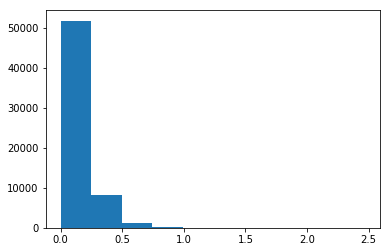

In [4]:
#Find angular separation of cross match between GAIA and 2MASS
print(np.mean(GTab['angular_distance']))
print(np.min(GTab['angular_distance']))
print(np.max(GTab['angular_distance']))
print(np.std(GTab['angular_distance']))
plt.hist(GTab['angular_distance'])

In [5]:
#creates list of indentifiers from 2MASS?
gaia_list = []
for i in range(0,len(G2MASS)):
    gaia_list.append(G2MASS[i].decode('utf-8'))

In [6]:
#read in gould belt YSO catalog
infile = "Data/SERAQU-YSOs.tbl"
GBYSO = Table.read(infile,format="ascii.ipac")
print(GBYSO.colnames)
GBYSOra = GBYSO["ra"]
GBYSOdec = GBYSO["dec"]
GBYSO2MASS = GBYSO["id2mass"]
print("Read ",len(GBYSOra)," YSOs from GB YSO catalog")

#match Gould Belt YSO and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
GBYSO_match = np.empty(len(GBYSO2MASS),dtype=int); GBYSO_match.fill(-2)
for j in range(0,len(GBYSO2MASS)):
    if(GBYSO2MASS[j] in gaia_list):
        GBYSO_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

['GBS_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [7]:
#read in gould belt stars + dust catalgog
infile = "Data/SERP_GB_star+dust.tbl"
GBSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
GBSDra = GBSD["ra"]
GBSDdec = GBSD["dec"]
GBSD2MASS = GBSD["id2mass"]
print("Read ",len(GBSDra)," YSOs from GB Star+Dust catalog")

#match Gould Belt stars+dust and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
GBSD_match = np.empty(len(GBSD2MASS),dtype=int); GBSD_match.fill(-2)
for j in range(0,len(GBSD2MASS)):
    if(GBSD2MASS[j] in gaia_list):
        GBSD_match[j] = gaia_list.index(GBSD2MASS[j])
    else:
        GBSD_match[j] = -2
good_GBSD = GBSD_match > -1
print(len(GBSD_match[good_GBSD]))
print(np.where(GBSD_match > -1))

Read  3725  YSOs from GB Star+Dust catalog
97
(array([ 690,  744,  749,  850,  891,  893,  949,  989, 1170, 1185, 1213,
       1280, 1291, 1311, 1336, 1400, 1401, 1414, 1437, 1470, 1506, 1583,
       1627, 1721, 1764, 1781, 1793, 1799, 1880, 1907, 1956, 2005, 2079,
       2107, 2178, 2186, 2188, 2194, 2212, 2219, 2223, 2226, 2233, 2254,
       2304, 2330, 2572, 2615, 2642, 2751, 2752, 2859, 2902, 2920, 2956,
       3084, 3119, 3127, 3129, 3133, 3136, 3138, 3170, 3175, 3213, 3267,
       3271, 3287, 3304, 3310, 3326, 3330, 3344, 3346, 3366, 3369, 3372,
       3375, 3380, 3406, 3417, 3435, 3465, 3478, 3480, 3488, 3489, 3494,
       3501, 3512, 3521, 3530, 3542, 3549, 3625, 3697, 3719]),)


In [8]:
#read in c2d YSO catalog 
infile = "Data/catalog-SER-YSOc.tbl"
c2dYSO = Table.read(infile,format="ascii.ipac")
print(c2dYSO.colnames)
c2dYSOra = c2dYSO["ra"]
c2dYSOdec = c2dYSO["dec"]
c2dYSO2MASS = c2dYSO["id2mass"]
c2dYSOobj = c2dYSO["object_type"]
print("Read ",len(c2dYSOra)," YSOs from c2d YSO catalog")

#match c2d YSO and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
c2dYSO_match = np.empty(len(c2dYSO2MASS),dtype=int); c2dYSO_match.fill(-2)
for j in range(0,len(c2dYSO2MASS)):
    if(c2dYSO2MASS[j] in gaia_list):
        c2dYSO_match[j] = gaia_list.index(c2dYSO2MASS[j])
    else:
        c2dYSO_match[j] = -2
good_c2dYSO = c2dYSO_match > -1
print(len(c2dYSO_match[good_c2dYSO]))
print(np.where(c2dYSO_match > -1))

['c2d_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [9]:
#read in c2d YSO stars+dust catalog
infile = "Data/SERP_c2d_star+dust.tbl"
c2dSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
c2dSDra = c2dSD["ra"]
c2dSDdec = c2dSD["dec"]
c2dSD2MASS = c2dSD["id2mass"]
print("Read ",len(c2dSDra)," YSOs from c2d Star+Dust catalog")

#match c2d stars+dust and GAIA using 2MASS identifiers
#create array of indices where there is a match. A value of -2 inidcates no match to GAIA
c2dSD_match = np.empty(len(c2dSD2MASS),dtype=int); c2dSD_match.fill(-2)
for j in range(0,len(c2dSD2MASS)):
    if(c2dSD2MASS[j] in gaia_list):
        c2dSD_match[j] = gaia_list.index(c2dSD2MASS[j])
    else:
        c2dSD_match[j] = -2
good_c2dSD = c2dSD_match > -1
print(len(c2dSD_match[good_c2dSD]))
print(np.where(c2dSD_match > -1))

Read  256  YSOs from c2d Star+Dust catalog
24
(array([  2,  29,  51,  54, 126, 128, 142, 147, 153, 156, 171, 175, 191,
       193, 201, 214, 217, 219, 223, 224, 228, 235, 238, 251]),)


# Analyze Data

In [9]:
#total number of YSO matches

#create array of YSO matches
YSO_match = c2dYSO_match; YSO_match = np.append(YSO_match,GBYSO_match)
good_YSO = YSO_match > -1
print("Total number of GAIA matches to YSOs: ",len(YSO_match[good_YSO]))

#Create array of Star + Dust matches
SD_match = c2dSD_match; SD_match = np.append(SD_match,GBSD_match)
good_SD = SD_match > -1
print("Total number of GAIA matches to star+dust: ",len(SD_match[good_SD]))

#Create array of all YSO and stars+dust matches
ALL_match = YSO_match
ALL_match = np.append(ALL_match,SD_match)
good_ALL = ALL_match > -1
print("Total number of all matches: ",len(ALL_match[good_ALL]))

Total number of GAIA matches to YSOs:  195
Total number of GAIA matches to star+dust:  121
Total number of all matches:  316


In [10]:
#Find the radial velocites of YSOs within 350 and 550 pc
num = 0
for i in range(len(YSO_match)):
    if (YSO_match[i] > -1):
        j = YSO_match[i]
        if (Gdist[j] >= 350 and Gdist[j] <= 550):
            print(GTab['radial_velocity'][j])
            num=num+1
print(num)

--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
-36.2672497918
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
-9.35264566801
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
-20.5183784367
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
-25.7820161518
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
--
147


In [11]:
#Coordinates that indicate the borders (in RA and Dec) of rectangular regions in 
#Serpens that contain sources used for analysis

#Serpens East
ra_min1 = 279
ra_max1 = 280.1
dec_min1 = -1
dec_max1 = 1
width1 = (ra_max1-ra_min1)
height1 = (dec_max1 - dec_min1)

#Borders for Serpens East region 
sky_region1 = [ra_min1,ra_max1,dec_min1,dec_max1]

#Region that contains all of W40, Serpens South, and West Arm
ra_min2 = 276.5
ra_max2 = 278.5
dec_min2 = -4.25
dec_max2 = -1.4
width2 = (ra_max2-ra_min2)
height2 = (dec_max2 - dec_min2)

#Borders for region that encloses W40, Serpens South, and West Arm
sky_region2 = [ra_min2,ra_max2,dec_min2,dec_max2]

#Region that contins both W40 and Serpens South
dec_split2 = -3.0
ra_min2u = ra_min2
ra_max2u = ra_max2
dec_min2u = dec_split2
dec_max2u = dec_max2
width2u = (ra_max2u-ra_min2u)
height2u = (dec_max2u-dec_min2u)

#Borders for region that encloses W40 and serpens south
sky_region2u = [ra_min2u,ra_max2u,dec_min2u,dec_max2u]

#West Arm
ra_min2d = ra_min2
ra_max2d = ra_max2
dec_min2d = dec_min2
dec_max2d = dec_split2
width2d = (ra_max2d-ra_min2d)
height2d = (dec_max2d-dec_min2d)

#Borders for West Arm Region
sky_region2d = [ra_min2d,ra_max2d,dec_min2d,dec_max2d]

#W40
ra_split2 = 277.45
ra_minW40 = ra_split2
ra_maxW40 = ra_max2
dec_minW40 = dec_min2u
dec_maxW40 = dec_max2u
widthW40 = (ra_maxW40-ra_minW40)
heightW40 = (dec_maxW40-dec_minW40)

#Borders for W40
sky_regionW40 = [ra_minW40,ra_maxW40,dec_minW40,dec_maxW40]

# Serpens South
ra_minS = ra_min2
ra_maxS = ra_split2
dec_minS = dec_min2u
dec_maxS = dec_max2u
widthS = (ra_maxS-ra_minS)
heightS = (dec_maxS-dec_minS)

#Borders for Serpens South 
sky_regionS = [ra_minS,ra_maxS,dec_minS,dec_maxS]

#Region that contains both Serpens Main and Serpens B
ra_min3 = 276.75
ra_max3 = 277.75
dec_min3 = -1
dec_max3 = 2
width3 = (ra_max3-ra_min3)
height3 = (dec_max3 - dec_min3)

#Borders for region that contains Serpens Main and Serpens B 
sky_region3 = [ra_min3,ra_max3,dec_min3,dec_max3]

#Serpens Main
dec_split3 = 0.4
ra_min3u = ra_min3
ra_max3u = ra_max3
dec_min3u = dec_split3
dec_max3u = dec_max3
width3u = (ra_max3u-ra_min3u)
height3u = (dec_max3u - dec_min3u)

#Borders for Serpens  Main
sky_region3u = [ra_min3u,ra_max3u,dec_min3u,dec_max3u]

#Serpens B
ra_min3d = ra_min3
ra_max3d = ra_max3
dec_min3d = dec_min3
dec_max3d = dec_split3
width3d = (ra_max3d-ra_min3d)
height3d = (dec_max3d - dec_min3d)

#Borders for Serpens South
sky_region3d = [ra_min3d,ra_max3d,dec_min3d,dec_max3d]

In [12]:
def CalculateProperties(star_type,match,Gvalues,distance_range = [0.,630.],sky_region = [273.99,280.99,-5.,2.],\
                        adj=[0,0,0,0]):
    '''
    Function to calculate the properties sources (YSO, star+dust or both) 
    that have been cross matched with GAIA in a given region and distance range
    Prints out properties and plots histograms and spatial plots of the data. 
    
    Inputs:
    star_type: String that describes region
    match: Array of indices of sources (YSO or Star+Dust) in GAIA table. 
           Sources that do not have match have value of -2
    Gvalues: Dictionary that contains columns from GAIA table
    distance rage: Distance range for sources. Default is [0,630]
    sky_region: Borders of region in which sources are located. Default is entire Serpens Cloud[273.99,280.99,-5.,2.]
    adj: Values to add to xlimit and ylimit to extend the plot region. Default is [0,0,0,0]
    
    Outputs:
    result: Dictionary that contains arrays of properties of sources within specified distance and region
    '''
    
    #create arrays that will contain properties about sources within a region 
    good_match = match > -1
    identifiers = np.array([])      #2MASS identifiers
    ra_match = np.array([])         #RA coordinates
    dec_match = np.array([])        #Dec coordinates
    pmra_match = np.array([])       #proper motion in RA
    pmdec_match = np.array([])      #proper motion in Dec
    pmra_e_match = np.array([])     #proper motion error in RA
    pmdec_e_match = np.array([])    #proper motion error in Dec
    par_match = np.array([])        #parallax
    par_e_match = np.array([])      #parallax error
    par_sn_match = np.array([])     #parallax signal to noise
    dist_match = np.array([])       #distance
    pmra_km_match = np.array([])    #velocity in RA
    pmdec_km_match = np.array([])   #velocity in Dec
    pmra_e_match = np.array([])     #error in proper motion in RA
    pmdec_e_match = np.array([])    #error in proper motion in Dec
    pmra_km_e_match = np.array([])  #error in velocity in RA
    pmdec_km_e_match = np.array([]) #error in velocity in RA
    n = 0

    #Add propeties to arrays of sources that meet distance and region condition
    for i in range(0,len(match)):
        #Source must have GAIA match
        if(match[i] > -1):
            #Index in GAIA catalog
            j = match[i]
            #Filter sources according to distance and region in the sky
            if(Gvalues['Dist'][j] >= distance_range[0] and Gvalues['Dist'][j] <= distance_range[1] \
                and Gvalues['ra'][j] > sky_region[0] and Gvalues['ra'][j] < sky_region[1] \
                and Gvalues['dec'][j] > sky_region[2] and Gvalues['dec'][j] < sky_region[3]):
                    identifiers = np.append(identifiers,j)
                    ra_match = np.append(ra_match,Gvalues['ra'][j])
                    dec_match = np.append(dec_match,Gvalues['dec'][j])
                    pmra_match = np.append(pmra_match,Gvalues['pmra'][j])
                    pmdec_match = np.append(pmdec_match,Gvalues['pmdec'][j])
                    par_match = np.append(par_match,Gvalues['parallax'][j])
                    par_e_match = np.append(par_e_match,Gvalues['parallax_error'][j])
                    par_sn_match = np.append(par_sn_match,Gvalues['par_over_e'][j])
                    dist_match = np.append(dist_match,Gvalues['Dist'][j])
                    pmra_km_match = np.append(pmra_km_match,Gvalues['pmra_km'][j])
                    pmdec_km_match = np.append(pmdec_km_match,Gvalues['pmdec_km'][j])
                    pmra_e_match = np.append(pmra_e_match,Gvalues['pmra_error'][j])
                    pmdec_e_match = np.append(pmdec_e_match,Gvalues['pmdec_error'][j])
                    pmra_km_e_match = np.append(pmra_km_e_match,Gvalues['pmra_km_e'][j])
                    pmdec_km_e_match = np.append(pmdec_km_e_match,Gvalues['pmdec_km_e'][j])
                    n=n+1
    print("Number of "+ star_type +" matches in the correct distance interval:",n)
    
    #Find number of match within parallax S/N greater than 5,10 and 20
    parsn5 = par_sn_match > 5.
    parsn10 = par_sn_match > 10.
    parsn20 = par_sn_match > 20.
    print("Number of _match with parallax > 5, 10, 20: ", \
          len(par_sn_match[parsn5]),len(par_sn_match[parsn10]),len(par_sn_match[parsn20]))
    
    #mean velocity of region (determined using stars siwth paralax S/N >10)
    mean_pmra = np.mean(pmra_km_match[parsn10])
    mean_pmdec = np.mean(pmdec_km_match[parsn10])
    
    #error in mean velocity (determined using stars siwth paralax S/N >10)
    mean_pmra_err = np.std(pmra_km_match[parsn10])/np.sqrt(len(pmra_km_match[parsn10]))
    mean_pmdec_err = np.std(pmdec_km_match[parsn10])/np.sqrt(len(pmdec_km_match[parsn10]))
    
    #median velocity of region (determined using stars siwth paralax S/N >10)
    median_pmra = np.median(pmra_km_match[parsn10])
    median_pmdec = np.median(pmdec_km_match[parsn10])
    
    #error in median velocity (determined using stars siwth paralax S/N >10)
    median_pmra_err = np.sqrt(np.pi/2)*mean_pmra_err
    median_pmdec_err = np.sqrt(np.pi/2)*mean_pmdec_err
    
    #relative velocity with respect to median
    rpmra_match = pmra_km_match - median_pmra
    rpmdec_match = pmdec_km_match - median_pmdec
    
    #error of relative velocity with respect to median
    rpmra_err_match = np.sqrt(np.square(median_pmra_err)+np.square(pmra_km_e_match))
    rpmdec_err_match = np.sqrt(np.square(median_pmdec_err)+np.square(pmdec_km_e_match))
    
    #magnitude of relative velocity
    rpmmag_match = np.zeros(len(match[good_match]))
    rpmmag_match = np.power((rpmra_match*rpmra_match+rpmdec_match*rpmdec_match),0.5)
    
    #error in magnitude of relative velocity
    rpmmag_err_match = np.sqrt((rpmra_match*rpmra_err_match)**2+(rpmdec_match*rpmdec_err_match)**2)/rpmmag_match
    
    #magnitude of velocity
    pmmag_match = np.sqrt(np.square(pmra_km_match)+np.square(pmdec_km_match))
    pmmag_err_match = (np.sqrt((pmra_km_match*pmra_km_e_match)**2+pmdec_km_match*pmdec_km_e_match)**2)/pmmag_match
    
    #mean and median of velocity
    mean_pmmag = np.mean(pmmag_match)
    median_pmmag = np.median(pmmag_match)
    mean_pmmag_err = np.std(pmmag_match)/np.sqrt(len(pmmag_match))
    median_pmmag_err = np.sqrt(np.pi/2)*mean_pmmag_err
    
    #Standard deviation of magnitude of velocity 
    pmmag_std = np.std(pmmag_match)
    
    #Standard deviation of parallax
    par_std = np.std(par_match)
    
    #Median of parallax
    par_median = np.median(par_match)
    
    #print info
    print('For parallax S/N > 10:')
    print('The mean velocity in ra is ',mean_pmra,'+/-',mean_pmra_err)
    print('The mean velocity in dec is ',mean_pmdec,'+/-',mean_pmdec_err)
    print('The median velocity in ra is ',median_pmra,'+/-',median_pmra_err)
    print('The median proper velocity in dec is ',median_pmdec,'+/-',median_pmdec_err)
    print('For all YSOs:')
    print('The mean magnitude of velocity is',mean_pmmag,'+/-',mean_pmmag_err)
    print('The median magnitude of velocity is',median_pmmag,'+/-',median_pmmag_err)
    print('The standard deviation of velocity is',pmmag_std)
    print('The median parallax is',par_median,'with a standard deviation of ',par_std)
    
    #PLOTS
    
    #scatter plot of ra and dec
    plt.scatter(ra_match[parsn5],dec_match[parsn5],s=5)
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of YSOs in '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    
    #scatter plot of proper motions
    plt.scatter(pmra_match[parsn5],pmdec_match[parsn5],s=5)
    plt.xlabel('Proper motion in Right Ascension (mas/s)')
    plt.ylabel('Proper motion in Declination (mas/s)')
    plt.title('Proper Motions of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    
    #scatter plot of velocities (km/s)
    plt.scatter(pmra_km_match[parsn5],pmdec_km_match[parsn5],s=5)
    plt.xlabel('Velocity in Right Ascension (km/s)')
    plt.ylabel('Velocity in Declination (km/s)')
    plt.title('Velocities of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    
    
    #histograms of pmra, pmdec, pmmag, rpmra, rpmdec, rpmmag
    plt.hist(pmra_km_match)
    plt.title('Velocity in RA')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(pmdec_km_match)
    plt.title('Velocity in Dec')
    plt.xlabel('Velocity (km/s)')
    plt.show()
    plt.hist(pmmag_match,bins=15)
    plt.title('Magnitude of Velocity')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(rpmra_match)
    plt.title('Velocity Relative to Median in RA')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(rpmdec_match)
    plt.title('Velocity Relative to Median in Dec')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(rpmmag_match,bins=15)
    plt.title('Magnitude of Relative Velocity')
    plt.xlabel('Magnitude of Relative Velocity (km/s)')
    plt.ylabel('Count')
    name2 = "Figures/rpmmag_histogram_"+star_type.replace(" ","")+".png"
    plt.savefig(name2, dpi =300)
    plt.show()
    
    #Errorbar plot of magnitude of relative velocity against parallax
    plt.errorbar(par_match,rpmmag_match,yerr = rpmmag_err_match,xerr=par_e_match,linestyle='none',marker='o',color='k')
    plt.xlabel('Parallax (mas)')
    plt.ylabel('Magnitude of Relative Velocity (km/s)')
    plt.title('Magnitude of Relative Velocity vs. Parallax')
    plt.savefig("Figures/rpmmag_errorbar_"+star_type.replace(" ","")+".png", dpi=300)
    plt.show()
    
    #Errorbar plot of magnitude velocity against parallax 
    plt.errorbar(par_match,pmmag_match,yerr = pmmag_err_match,xerr=par_e_match,linestyle='none',marker='o',color='k')
    plt.xlabel('Parallax (mas)')
    plt.ylabel('Magnitude of Velocity (km/s)')
    plt.show()
    
    #plot of matches at ra and dec with velocity indicated as arrow
    plt.quiver(ra_match,dec_match,pmra_km_match,pmdec_km_match,pmmag_match)
    plt.axis('equal')
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of '+star_type)
    plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
    plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
    plt.gca().invert_xaxis()
    c = plt.colorbar()
    c.set_label('Magnitude of Velocity (km/s)')
    name1 = "Figures/pmmag__"+star_type.replace(" ","")+".png"
    plt.savefig(name1,dpi = 300)
    plt.show()
    
    #plot of matches at ra and dec with relative velocity indicated as arrow
    plt.quiver(ra_match,dec_match,rpmra_match,rpmdec_match,rpmmag_match)
    plt.axis('equal')
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Spatial Distribution of '+star_type)
    plt.xlim(sky_region[0]-adj[0],sky_region[1]+adj[1])
    plt.ylim(sky_region[2]-adj[2],sky_region[3]+adj[3])
    plt.gca().invert_xaxis()
    c = plt.colorbar()
    c.set_label('Magnitude of Relative Velocity (km/s)')
    plt.savefig("Figures/rpmmag_plot_"+star_type.replace(" ","")+".png",dpi=300)
    plt.show() 
    
    
    
   
    #Dictionary of properties of sources within region and distance range 
    result = {'ra':ra_match,'dec':dec_match,'pmra':pmra_match,'pmra_e':pmra_e_match, 'pmdec':pmdec_match, 
             'pmdec_e':pmdec_e_match,'par':par_match,'par_e':par_e_match,'par_sn':par_sn_match,'dist':dist_match, 
             'pmra_km':pmra_km_match,'pmra_km_e':pmra_km_e_match,'pmdec_km':pmdec_km_match,
             'pmdec_km_e':pmdec_km_e_match,'mean_pmra':mean_pmra,'mean_pmra_err':mean_pmra_err,
             'mean_pmdec':mean_pmdec,'mean_pmdec_err':mean_pmdec_err,'median_pmra':median_pmra,
             'median_pmra_err':median_pmra_err,'median_pmdec':median_pmdec,'median_pmdec_err':median_pmdec_err,
             'rpmra':rpmra_match,'rpmra_e':rpmra_err_match,
             'rpmdec':rpmdec_match,'rpmdec_e':rpmdec_err_match,'rpmmag':rpmmag_match,'rpmmag_err':rpmmag_err_match,
             'pmmag':pmmag_match, 'pmmag_err':pmmag_err_match,'mean_pmmag':mean_pmmag,
             'mean_pmmag_err':mean_pmmag_err, 'median_pmmag':median_pmmag,'median_pmmag_err':median_pmmag_err,
             'parsn5':parsn5,'parsn10':parsn10,'parsn20':parsn20,'id':identifiers,'pmmag_std':pmmag_std,
             'par_std':par_std}
    
    return result
            

In [13]:
def ConditionToRegion(region,parsn):
    '''
    Function to calculate the properties of sources in a region that have parallax S/N greater than a certain amount
    Prints out properties and plots histograms. 
    
    Inputs:
    region: Dictionary of properties determined for a region by the function
    parsn: Condition for parallax S/N to be greater than specified amount
    
    Outputs:
    none
    '''
    
    #magnitude of velocity
    pmmag_match = np.sqrt(np.square(region['pmra_km'][parsn])+np.square(region['pmdec_km'][parsn]))
    
    #error in magnitude of velocity
    pmmag_err_match = (np.sqrt(np.square(region['pmra_km'][parsn]*region['pmra_km_e'][parsn])+\
                        np.square(region['pmdec_km'][parsn]*region['pmdec_km_e'][parsn])))/pmmag_match
    
    #mean magnitude of velocity
    mean_pmmag = np.mean(pmmag_match)
    
    #median magnitude of velocity
    median_pmmag = np.median(pmmag_match)
    
    #error in mean magnitude of velocity
    mean_pmmag_err = np.std(pmmag_match)/np.sqrt(len(pmmag_match))
    
    #error in median magnitude of velocity
    median_pmmag_err = np.sqrt(np.pi/2)*mean_pmmag_err
    
    #standard deviation of velocity
    pmmag_std = np.std(pmmag_match)
    
    #standard deviation of parallax
    par_std = np.std(region['par'][parsn])
    
    #median of parallax
    par_median = np.median(region['par'][parsn])
    
    
    #Print Properties
    print('The median magnitude of proper motion is',median_pmmag,'+/-',median_pmmag_err)
    print('The standard deviation of proper motion is',pmmag_std)
    print('The median parallax is',par_median,'with a standard deviation of ',par_std)
    
    #histogram of pmra, pmdec, pmmag
    plt.hist(region['pmra_km'][parsn])
    plt.title('Velocity in RA')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(region['pmdec_km'][parsn])
    plt.title('Velocity in Dec')
    plt.xlabel('Proper Motion (km/s)')
    plt.show()
    plt.hist(pmmag_match,bins=15)
    plt.title('Magnitude of Velocity')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()

In [32]:
# Routines to convert magnitude to flux and vice versa for various wavebands.
#
# Additional wavebands can be added easily.
# MWP - Fri Jul 20 10:34:24 EDT 2018
#

# Mean wavelengths and effective bandwidths in angstroms & Zero Points in Jansky of various filters, 
# taken from VOSA website.  # http://svo2.cab.inta-csic.es/theory/fps/
# Format is dictionary of tuples:
#  {'Bandname':(Lambda_mean,BW_eff, ZP)}
#
sloan    = {'u':(3561.8,558.4,1568.5),'g':(4718.9,1158.4,3965.9),'r':(6185.2,1111.2,3162.0),'i':(7499.7,1044.6,2602.0),'z':(8961.5,1124.6,2244.7)}
# Gaia 2nd Release (GAIA2r) values
gaia    = {'BP':(5278.6,2279.4,3393.3),'G':(6773.7,4358.4,2835.1),'RP':(7919.1,2943.7,2485.1)}
twomass = {'J':(12350.0,1624.1,1594.0), 'H':(16620.0, 2509.4,1024.0), 'K':(21590.0,2618.9,666.8)}
spitzer = {'I1':(35572.6,6836.2,277.2), 'I2':(45049.3,8649.9,179.0), 'I3':(57385.7,12561.2,113.8), 'I4':(79273.7,25288.5,62.0), 'M24':(238433.1,52963.2,7.1), 'M70':(725555.3,213015.3,0.8), 'M160':(1569627.1,357530.2,0.2)}
herschel = {'PACSB':(719334.2,214148.9,0.8),'PACSG':(1026174.6,312860.0,0.4),'PACSR':(1671355.3,697595.3,0.1)}
#
# All filters -- Dictionary of dictionaries
#
filters = { "sloan": sloan, "gaia" : gaia, "twomass":twomass, "spitzer": spitzer, "herschel": herschel}

# Return given (milli)jansky
# Example: magtoflux("sloan","u",10)  returns 156.85 mJy 
def magtoflux(telescope,filter,magnitude,mjy=True):
    """Return the flux in Jansky or milliJansky of a source given its magnitude.
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          magnitude - magnitude of source
          mjy       - boolean to return flux in mJy. True returns mJy, False returns Jy. Default:True
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: zpjy *= 1000.0
    return zpjy*10.0**(magnitude/-2.5)

# Return magnitude given jansky
# @todo allow mJy input as well
# Requires "import numpy as np"
# Example: fluxtomag("sloan","u",156.85)  returns 10 mag
def fluxtomag(telescope,filter,flux,mjy=True):
    """Return the magnitude given flux in Jansky
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          flux      - flux of source in Jy or mJy
          mjy       - boolean, True if flux was given in mJy False if Jy
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: 
        cflux = 0.001
    else: 
        cflux = 1.0
    return -2.5*np.log10(cflux*flux/zpjy)

In [83]:
def CheckOutlier(Region,YSO_match,c2dYSO_match,GTab,Gdist,GBYSO,shift1,shift2):
    '''
    Function to identify the outliers based on relative velocity within a region.
    Prints information about the outliers and plots SED of outliers 
    
    Inputs:
    Region: Dictionary of properties determined for a region by the function
    YSO_match: Array of indices of YSOs in GAIA table. Sources that do not have match have value of -2
    c2dYSO_match: Array of indices of c2d YSOs table. Sources that do not have match have value of -2
    GTab: Table of GAIA data
    Gdist: Distances of GAIA sources
    GBYSO: Array of indices of GB YSOs in GAIA table. Sources that do not have match have value of -2
    shift1: Array of values used to shift the Planck Function in apparent flux SED plots
    shift2: Array of values used to shift the Planck Function in absolute flux SED plots
    
    Outputs: 
    none
    '''
    
    #get magnitudes from GAIA
    g = GTab["phot_g_mean_mag"]
    b = GTab["phot_bp_mean_mag"]
    r = GTab["phot_rp_mean_mag"]
    J = GTab["j_m"]
    H = GTab["h_m"]
    K = GTab["ks_m"]
    
    #get fluxes from GAIA
    g_flux = magtoflux('gaia','G',g,mjy=True)
    b_flux = magtoflux('gaia','BP',b,mjy=True)
    r_flux = magtoflux('gaia','RP',r,mjy=True)
    J_flux = magtoflux('twomass','J',J,mjy=True)
    H_flux = magtoflux('twomass','H',H,mjy=True)
    K_flux = magtoflux('twomass','K',K,mjy=True)
    
    #condition for outlier within region
    condition = Region['rpmmag']> 10     #(3*np.median(Region['rpmmag'])) condition for 3*median
    
    #relative velocity magnitude
    rpmmag = Region['rpmmag'][np.where(condition)]
    
    #relative velocity magnitude error
    rpmmag_err = Region['rpmmag_err'][np.where(condition)]
    
    #velolcity magnitude
    pmmag = Region['pmmag'][np.where(condition)]
    
    #velocity magnitude error
    pmmag_err = Region['pmmag_err'][np.where(condition)]
    
    #velocity magnitude ivided by error
    pmmag_over_error = Region['pmmag'][np.where(condition)]/Region['pmmag_err'][np.where(condition)]
    
    #velcity magnitude divided by median
    pmmag_over_median = Region['pmmag'][np.where(condition)]/Region['median_pmmag']
    
    #parallax
    plx = Region['par'][np.where(condition)]
    
    #parallax divided by error
    plx_over_error = Region['par'][np.where(condition)]/Region['par_e'][np.where(condition)]
    
    #Find GAIA id
    ids = Region['id'][condition]
    
    #Print number of outliers
    print('There are',len(ids),'outliers\n\n')
    
    #Loop through all of the outliers
    num = 0
    for i in range(len(ids)):
        
        id = int(ids[i])
        
        #Print information
        print('The index is ',np.argwhere(Region['rpmmag']==Region['rpmmag'][condition][num]))
        print('The GAIA list number is',id)
        print('The outlier is at a distance of', round(Gdist[id],2),'+/-',Gdist_e[id],'pc')
        print('The proper motion deviation magnitude is',rpmmag[i],'+/-',rpmmag_err[i],'km/s')
        print('The proper motion magnitude is ',pmmag[i],'+/-',pmmag_err[i],'km/s')
        print('pmmag/error (need to check)',pmmag_over_error[i])
        print('pmmag/median',pmmag_over_median[i])
        print('plx',plx[i])
        print('plx/error',plx_over_error[i])
        
        num = num+1
              
        #Find YSO id
        YSO_id = int(np.where(YSO_match==id)[0])
        
        #Find ID in gould belt or c2d
        GB_id = -100
        c2d_id = -100
        if (YSO_id > len(c2dYSO_match)):
            GB_id = YSO_id-len(c2dYSO_match)
            cid = GB_id
            important_id = GBYSO['GBS_ID'][cid]
            #Find difference in RA and Dec (in arcmin)
            ra_diff = np.abs(GTab['ra'][id]-GBYSO['ra'][cid])*60*60
            dec_diff = np.abs(GTab['dec'][id]-GBYSO['dec'][cid])*60*60
            print('The GB index',cid)
            print('The difference in RA is ',round(ra_diff,3), 'arcseconds')
            print('The difference in Dec is ',round(dec_diff,3), 'arcseconds')
            print('The Gould_Belt_ID is ',important_id)
            print('alpha is',GBYSO['alpha'][cid])
            print('The magnitude in K is',c2dYSO['K'][cid])
            
            #read in flux from GB
            IR1_flux = GBYSO['IR1_flux_c']
            IR2_flux = GBYSO['IR2_flux_c']
            IR3_flux = GBYSO['IR1_flux_c']
            IR4_flux = GBYSO['IR4_flux_c']
            MP1_flux = GBYSO['MP1_flux_c']
            MP2_flux = GBYSO['MP2_flux_c']
        else: 
            c2d_id = YSO_id
            cid = c2d_id
            important_id = c2dYSO['c2d_ID'][cid]
            #Find difference in RA and Dec (in arcmin)
            ra_diff = np.abs(GTab['ra'][id]-c2dYSO['ra'][cid])*60*60
            dec_diff = np.abs(GTab['dec'][id]-c2dYSO['dec'][cid])*60*60
            print('The c2d index is',cid)
            print('The difference in RA is ',ra_diff, 'arcseconds')
            print('The difference in Decliantion is ',dec_diff, 'arcseconds')
            print('The c2d_ID is ',important_id)
            print('alpha is',c2dYSO['alpha'][cid])
            print('The magnitude in K is',c2dYSO['K'][cid])
            
            #read in flux from c2d
            IR1_flux = c2dYSO['IR1_flux_c']
            IR2_flux = c2dYSO['IR2_flux_c']
            IR3_flux = c2dYSO['IR1_flux_c']
            IR4_flux = c2dYSO['IR4_flux_c']
            MP1_flux = c2dYSO['MP1_flux_c']
            MP2_flux = c2dYSO['MP2_flux_c']
            
        #Calculate Magnitudes
        IR1 = fluxtomag('spitzer','I1',IR1_flux,mjy=True)
        IR2 = fluxtomag('spitzer','I2',IR2_flux,mjy=True)
        IR3 = fluxtomag('spitzer','I3',IR3_flux,mjy=True)
        IR4 = fluxtomag('spitzer','I4',IR4_flux,mjy=True)
        MP1 = fluxtomag('spitzer','M24',MP1_flux,mjy=True)
        MP2 = fluxtomag('spitzer','M70',MP2_flux,mjy=True)
        
        #absolute magnitude in each filter
        g_abs = g[id] - 5*np.log10(Gdist[id]) + 5
        b_abs = b[id] - 5*np.log10(Gdist[id]) + 5
        r_abs = r[id] - 5*np.log10(Gdist[id]) + 5
        J_abs = J[id] - 5*np.log10(Gdist[id]) + 5
        H_abs = H[id] - 5*np.log10(Gdist[id]) + 5
        K_abs = K[id] - 5*np.log10(Gdist[id]) + 5
        IR1_abs = IR1[cid] - 5*np.log10(Gdist[id]) + 5
        IR2_abs = IR2[cid] - 5*np.log10(Gdist[id]) + 5
        IR3_abs = IR3[cid] - 5*np.log10(Gdist[id]) + 5
        IR4_abs = IR4[cid] - 5*np.log10(Gdist[id]) + 5
        MP1_abs = MP1[cid] - 5*np.log10(Gdist[id]) + 5
        MP2_abs = MP2[cid] - 5*np.log10(Gdist[id]) + 5
        
        #absoulte flux in each filter
        g_flux_abs = np.power((Gdist[id]/10),2)*g_flux[id]
        b_flux_abs = np.power((Gdist[id]/10),2)*b_flux[id]
        r_flux_abs = np.power((Gdist[id]/10),2)*r_flux[id]
        J_flux_abs = np.power((Gdist[id]/10),2)*J_flux[id]
        H_flux_abs = np.power((Gdist[id]/10),2)*H_flux[id]
        K_flux_abs = np.power((Gdist[id]/10),2)*K_flux[id]
        IR1_flux_abs = np.power((Gdist[id]/10),2)*IR1_flux[cid]
        IR2_flux_abs = np.power((Gdist[id]/10),2)*IR2_flux[cid]
        IR3_flux_abs = np.power((Gdist[id]/10),2)*IR3_flux[cid]
        IR4_flux_abs = np.power((Gdist[id]/10),2)*IR4_flux[cid]
        MP1_flux_abs = np.power((Gdist[id]/10),2)*MP1_flux[cid]
        MP2_flux_abs = np.power((Gdist[id]/10),2)*MP2_flux[cid]
            
    
        #Apparent Magnitude SED
        SED = np.array([b[id],g[id],r[id],J[id],H[id],K[id],IR1[cid],IR2[cid],IR3[cid],\
                        IR4[cid],MP1[cid]])
        wvl = np.array([gaia['BP'][0],gaia['G'][0],gaia['RP'][0],twomass['J'][0],twomass['H'][0],twomass['K'][0],\
                    spitzer['I1'][0],spitzer['I2'][0],spitzer['I3'][0],spitzer['I4'][0],spitzer['M24'][0]])
        wvl_micro = wvl*10
        plt.plot(wvl_micro,SED,marker = 'o',linestyle='--')
        plt.gca().invert_yaxis()
        plt.xscale('log')
        plt.xlabel('Wavelength ($\mu$m)')
        plt.ylabel('Apparent Magnitude')
        plt.title('Apparent Magnitude SED of Outlier')
        plt.show()
                          
        #Absolute Magnitude SED
        SED_abs = np.array([b_abs,g_abs,r_abs,J_abs,H_abs,K_abs, IR1_abs, IR2_abs, IR3_abs, IR4_abs,MP1_abs])
        plt.plot(wvl_micro,SED_abs,marker = 'o',linestyle='--')
        plt.gca().invert_yaxis()
        plt.xscale('log')
        plt.xlabel('Wavelength ($\mu$m)')
        plt.ylabel('Absolute Magnitude')
        plt.title('Absolute Magnitude SED of Outlier')
        plt.show()
        
        #Flux SED
        #flux in Jy
        SED_flux= np.array([b_flux[id],g_flux[id],r_flux[id],J_flux[id],H_flux[id],K_flux[id],IR1_flux[cid],\
                    IR2_flux[cid], IR3_flux[cid],IR4_flux[cid], MP1_flux[cid]])*np.power(10.,-3)
        #frequency (in Hz)
        nu = ((const.c.cgs.value)/(wvl*np.power(10.,-8)))
        #frequency (in GHz)
        Gnu = nu/(np.power(10,9))
        #multiply flux by frequency
        SED_nu = SED_flux*nu
        #plot nu*fnu
        plt.plot(Gnu,np.log10(SED_nu),marker = 'o',linestyle='--')
        plt.gca().invert_xaxis()
        #plot planck function
        T = 4000.
        B= ((2*const.h.cgs.value*np.power(nu,3))/(np.power(const.c.cgs.value,2)))*\
                (1/(np.exp((const.h.cgs.value*nu)/(const.k_B.cgs.value*T))-1))
        Bnu = B*nu
        plt.plot(Gnu,np.log10(Bnu)+shift1[i],label= r'$\nu\, B_{\nu}$ for T = 4,000 K')
        #plot Linear Fit
        [m1,b1] = np.polyfit(np.log10(nu[5:11]),np.log10(SED_nu[5:11]),deg=1)
        alpha = -m1
        B_lin = m1*np.log10(nu[5:11])+b1
        line_label = r'$\alpha$ = '+ str(round(alpha,2))
        plt.plot(Gnu[5:11],B_lin,label=line_label)
        #Labels
        plt.xscale('log')
        plt.xlabel(r'log10($\nu$) (GHz)')
        plt.ylabel(r'log10($\nu\, F_{\nu}$) (erg/s/cm$^2$)')
        plt.title('Apparent Flux SED of '+important_id)
        plt.legend()
        #plt.gca().invert_xaxis()
        plt.savefig('Figures/'+str(important_id).replace(" ","").replace(".","_")+"_apparent_flux_SED.png",dpi=300)
        plt.show()
        
        #Absolute Flux SED
        SED_flux_abs = np.array([b_flux_abs,g_flux_abs,r_flux_abs,J_flux_abs,H_flux_abs,K_flux_abs, \
                            IR1_flux_abs, IR2_flux_abs, IR3_flux_abs, IR4_flux_abs,MP1_flux_abs])
        #multiply flux by frequency
        SED_nu_abs = SED_flux_abs*nu 
        plt.plot(wvl_micro,np.log10(SED_nu_abs),marker = 'o',linestyle='--')
        #plot planck function
        plt.plot(wvl_micro,np.log10(Bnu)+shift2[i])
        #linear fit
        [m,b2] = np.polyfit(np.log10(wvl_micro[5:11]),np.log10(SED_nu_abs[5:11]),deg=1)
        B_lin = m*np.log10(wvl_micro[5:11])+b2
        line_label = 'y = '+str(round(m,2)) +' x + '+str(round(b2,2))
        plt.plot(wvl_micro[5:11],B_lin,label=line_label)
        plt.xscale('log')
        plt.xlabel('log10($\lambda$) ($\mu$m)')
        plt.ylabel('log10(v Fv) (erg/s/cm$^2$)')
        plt.title('Absolute Flux SED of '+important_id)
        plt.legend()
        plt.show()
       

# Analyze Regions

## ALL Sources

In [ ]:
YSO_East = CalculateProperties('Serpens East',ALL_match,Gvalues, distance_range=[350.,550.], \
                               sky_region = sky_region1,adj=[0,0,0,0])

ConditionToRegion(YSO_East,YSO_East['parsn10'])
print(YSO_East['pmmag'])

## YSOs

Number of YSOs matches in the correct distance interval: 147
Number of _match with parallax > 5, 10, 20:  135 86 43
For parallax S/N > 10:
The mean velocity in ra is  5.3662147971 +/- 0.341322215495
The mean velocity in dec is  -15.4528317677 +/- 0.753807814849
The median velocity in ra is  6.15771639764 +/- 0.427783958059
The median proper velocity in dec is  -17.056775125 +/- 0.944757991169
For all YSOs:
The mean magnitude of velocity is 17.5321506804 +/- 0.305989826478
The median magnitude of velocity is 18.1454271853 +/- 0.383501375399
The standard deviation of velocity is 3.70992948241
The median parallax is 2.23829890655 with a standard deviation of  0.231664642753


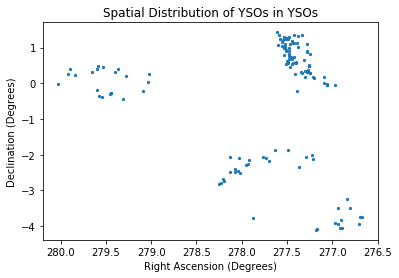

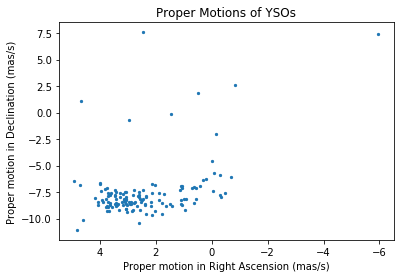

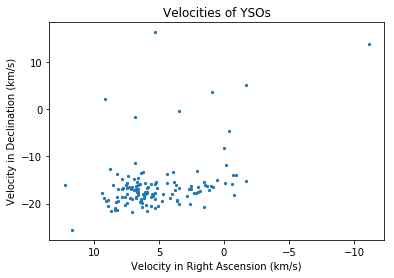

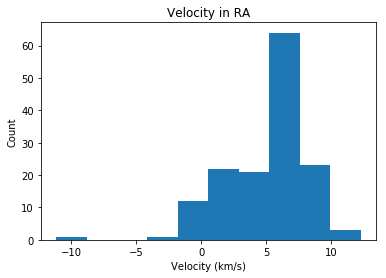

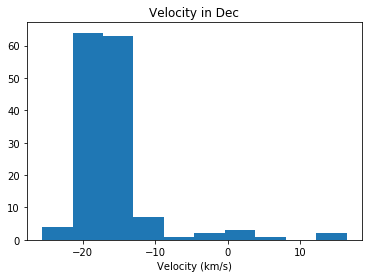

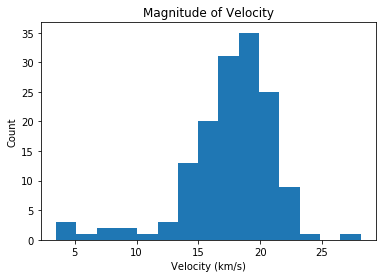

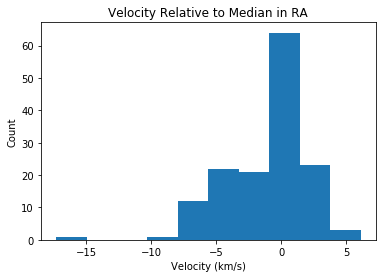

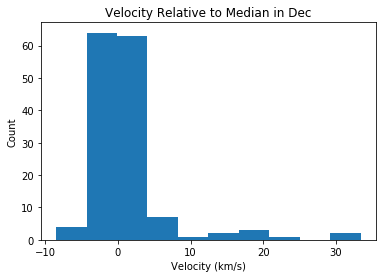

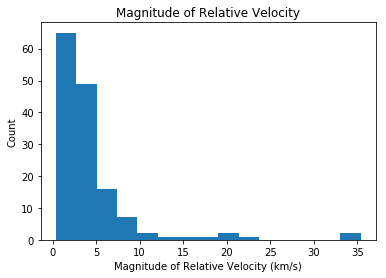

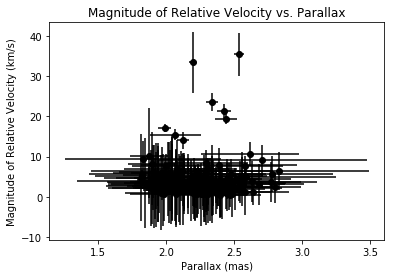

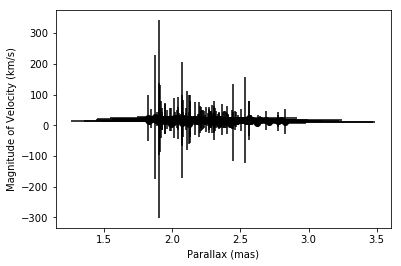

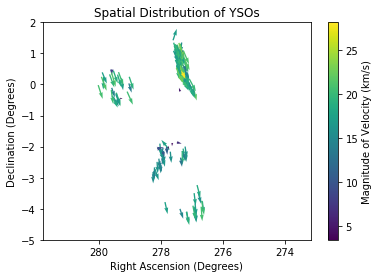

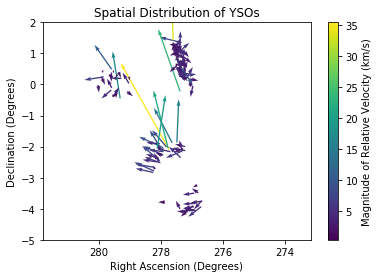

In [34]:
#All YSOs
adj1 = [0,0,0,0]
adj=[1,6,1,6]
YSO_all = CalculateProperties('YSOs',YSO_match,Gvalues,distance_range=[350.,550.])

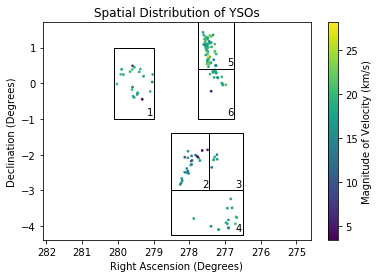

In [73]:
#Plot of selected YSOs
figure = plt.figure()
plt.scatter(YSO_all['ra'],YSO_all['dec'],c=YSO_all['pmmag'],s=3)
plt.axis('equal')
c = plt.colorbar()
c.set_label('Magnitude of Velocity (km/s)')
plt.xlabel('Right Ascension (Degrees)')
plt.ylabel('Declination (Degrees)')
plt.title('Spatial Distribution of YSOs')
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.text(ra_min1+0.2,dec_min1+0.1,'1')
plt.text(ra_minW40+0.2,dec_minW40+0.1,'2')
plt.text(ra_minS+0.2,dec_minS+0.1,'3')
plt.text(ra_min2d+0.2,dec_min2d+0.1,'4')
plt.text(ra_min3u+0.2,dec_min3u+0.1,'5')
plt.text(ra_min3d+0.2,dec_min3d+0.1,'6')
plt.gca().invert_xaxis()
plt.savefig("Figures/Regions.png",dpi=300)
plt.show()

## Serpens East

Number of Serpens East matches in the correct distance interval: 22
Number of _match with parallax > 5, 10, 20:  21 11 6
For parallax S/N > 10:
The mean velocity in ra is  6.0089971328 +/- 0.395395409157
The mean velocity in dec is  -16.2778365143 +/- 1.622345197
The median velocity in ra is  6.1340485743 +/- 0.495554656126
The median proper velocity in dec is  -18.4196102315 +/- 2.033308171
For all YSOs:
The mean magnitude of velocity is 17.4541101461 +/- 0.898752972216
The median magnitude of velocity is 18.7489619593 +/- 1.12641980603
The standard deviation of velocity is 4.21552510507
The median parallax is 2.08802426198 with a standard deviation of  0.209761884555


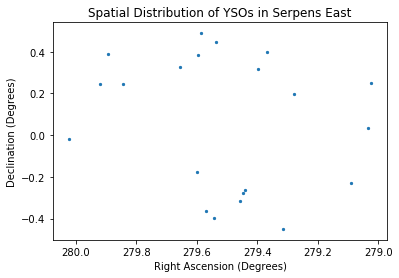

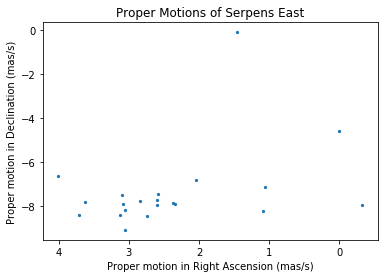

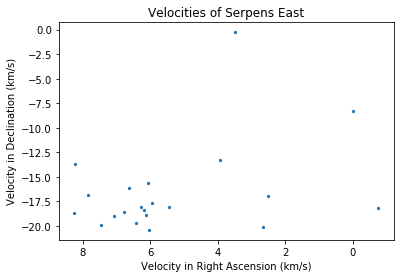

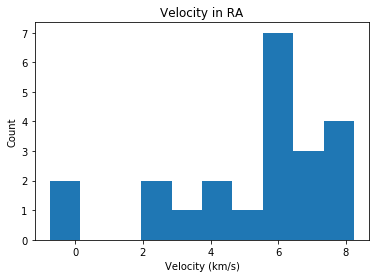

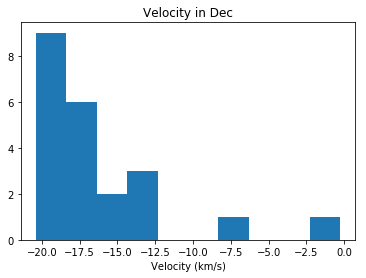

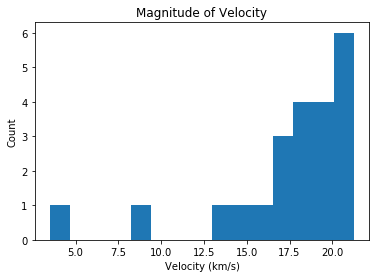

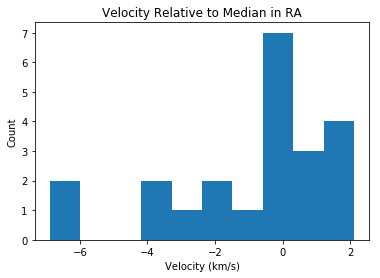

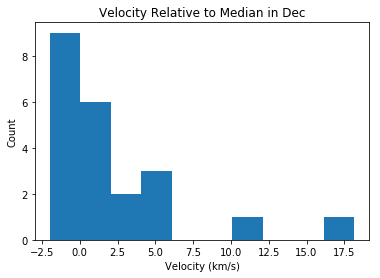

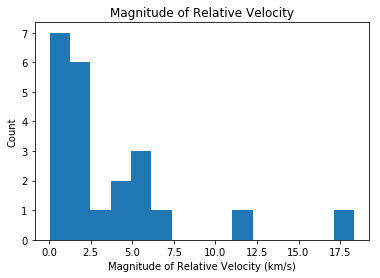

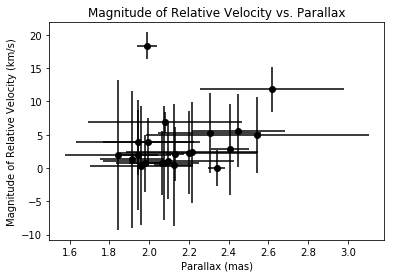

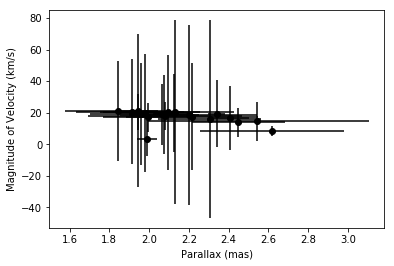

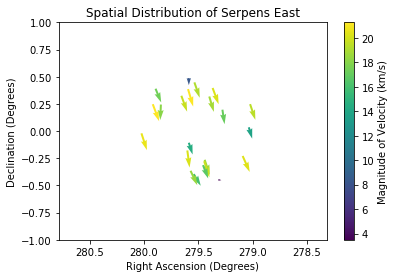

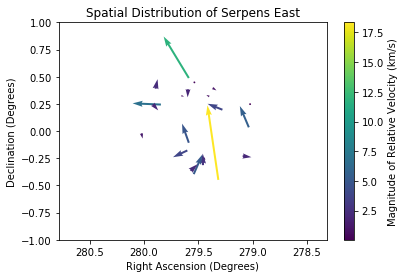

The median magnitude of proper motion is 19.4291418227 +/- 1.84162865888
The standard deviation of proper motion is 4.87347192759
The median parallax is 2.07505396736 with a standard deviation of  0.179167676907


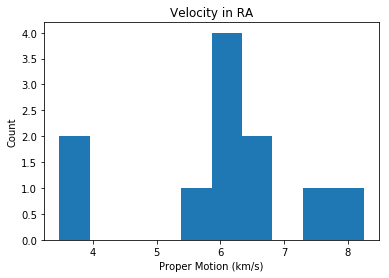

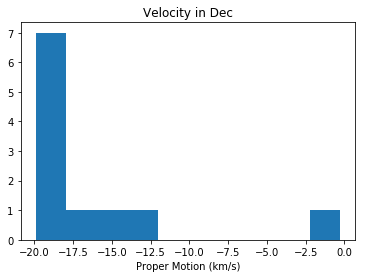

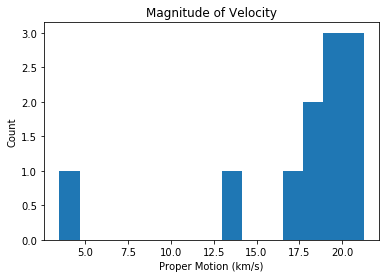

[ 19.42914182  13.81868208  20.44261718  17.16559278   3.48692097
  20.28240438  18.85050153  18.64742239  19.84416877  16.75096889
  19.12601888  15.9441673   18.56251182   8.31417022  14.48196263
  21.2769246   20.23673041  19.79740389  18.14542719  17.40622549
  21.2624354   20.71802459]


In [36]:
YSO_East = CalculateProperties('Serpens East',YSO_match,Gvalues, distance_range=[350.,550.], \
                               sky_region = sky_region1,adj=[0,0,0,0])

ConditionToRegion(YSO_East,YSO_East['parsn10'])
print(YSO_East['pmmag'])

## Serpens South

Number of Serpens South matches in the correct distance interval: 6
Number of _match with parallax > 5, 10, 20:  4 2 1
For parallax S/N > 10:
The mean velocity in ra is  1.93691763671 +/- 0.44141280022
The mean velocity in dec is  -16.1941329419 +/- 0.0156119693775
The median velocity in ra is  1.93691763671 +/- 0.553228902908
The median proper velocity in dec is  -16.1941329419 +/- 0.0195667019321
For all YSOs:
The mean magnitude of velocity is 16.3582122449 +/- 0.890130464014
The median magnitude of velocity is 16.3212302123 +/- 1.1156130946
The standard deviation of velocity is 2.18036544134
The median parallax is 2.0564806995 with a standard deviation of  0.193931892008


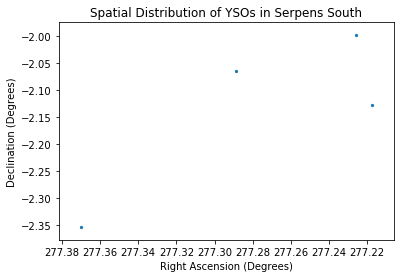

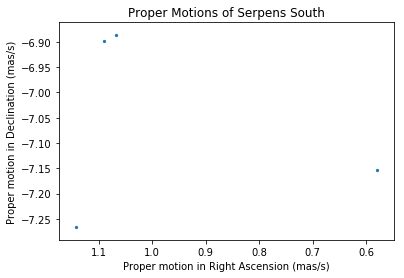

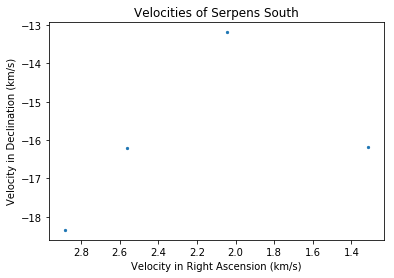

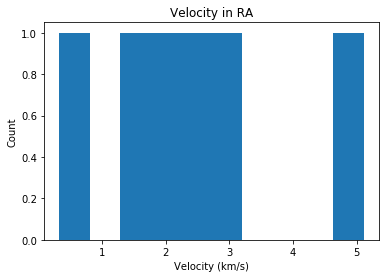

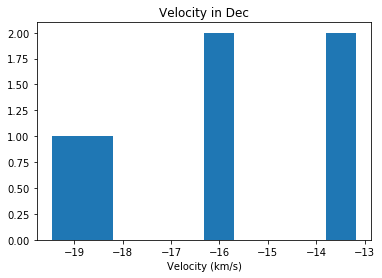

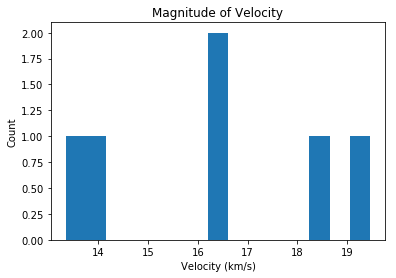

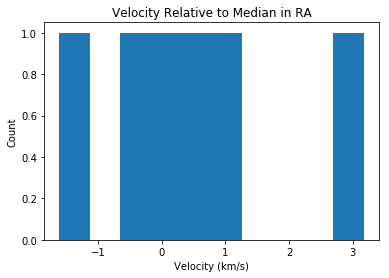

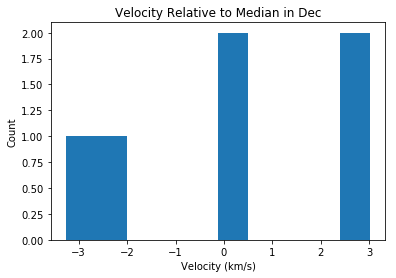

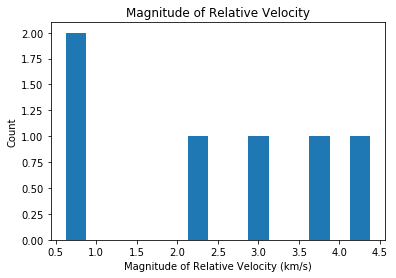

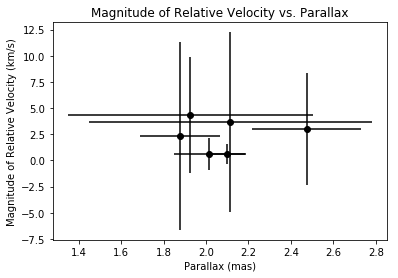

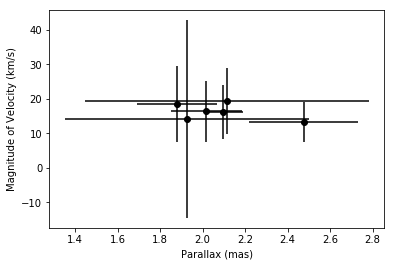

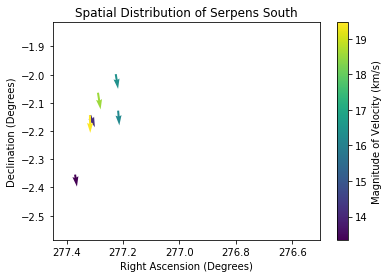

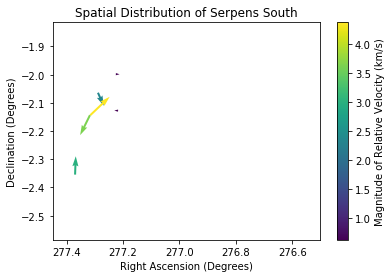

[276.5, 277.45, -3.0, -1.4]
The median magnitude of proper motion is 16.3212302123 +/- 0.0850686237154
The standard deviation of proper motion is 0.095989662774
The median parallax is 2.0564806995 with a standard deviation of  0.0402084726017


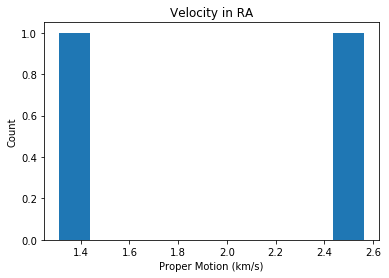

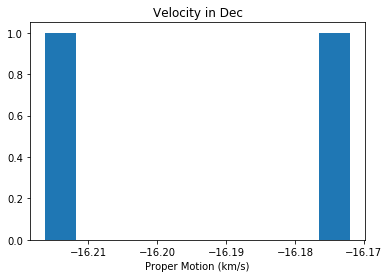

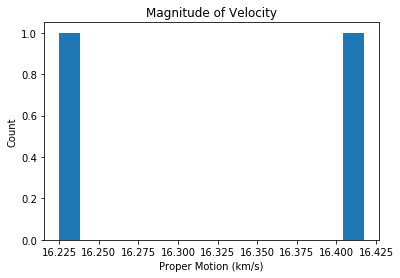

In [37]:
YSO_S = CalculateProperties('Serpens South',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionS,\
                           adj=[0,0,0,0])
print(sky_regionS)

ConditionToRegion(YSO_S,YSO_S['parsn10'])

## W40

Number of W40 matches in the correct distance interval: 23
Number of _match with parallax > 5, 10, 20:  19 12 8
For parallax S/N > 10:
The mean velocity in ra is  1.85400110478 +/- 1.41019681478
The mean velocity in dec is  -8.22228880241 +/- 2.90068802759
The median velocity in ra is  1.23770825225 +/- 1.76741960437
The median proper velocity in dec is  -15.6513880164 +/- 3.63547331292
For all YSOs:
The mean magnitude of velocity is 13.3630003613 +/- 0.82049518769
The median magnitude of velocity is 14.9507440298 +/- 1.02833821833
The standard deviation of velocity is 3.93495668585
The median parallax is 2.2953684808 with a standard deviation of  0.235813313045


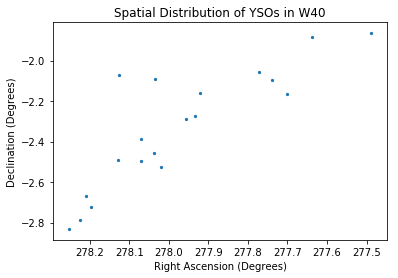

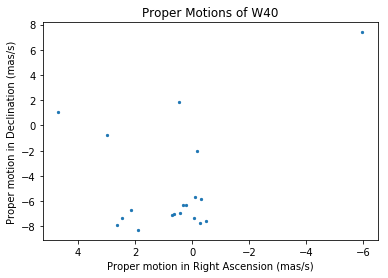

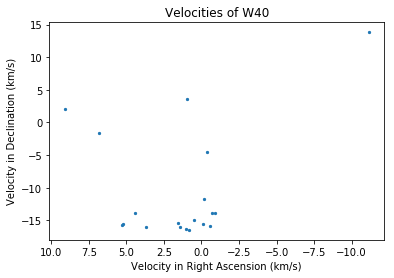

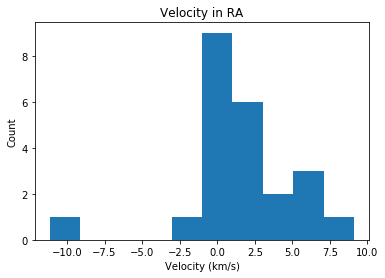

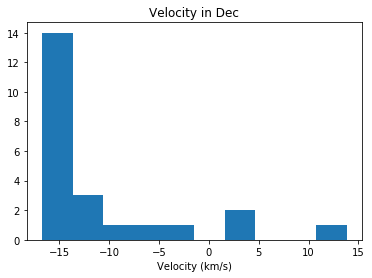

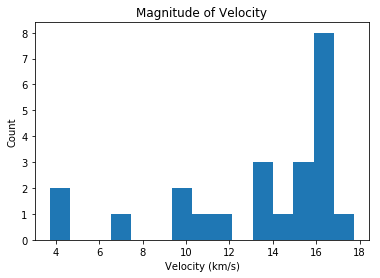

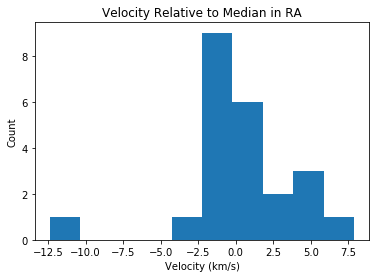

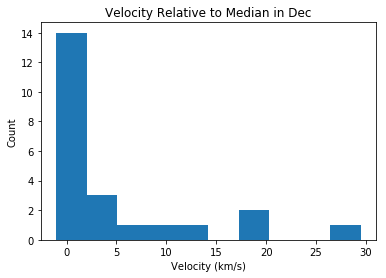

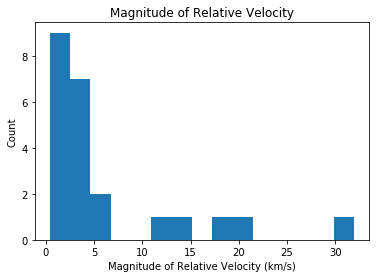

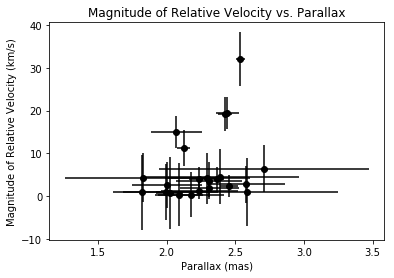

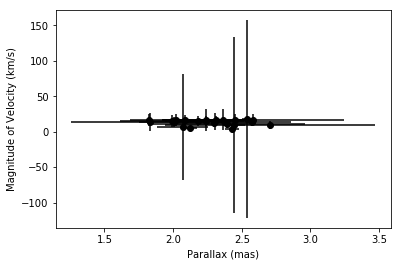

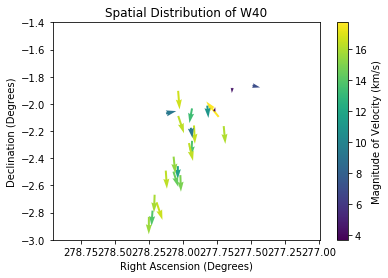

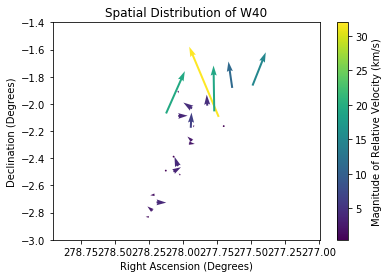

[277.45, 278.5, -3.0, -1.4]
The median magnitude of proper motion is 16.1961635896 +/- 1.82655620686
The standard deviation of proper motion is 5.04851586521
The median parallax is 2.27454746561 with a standard deviation of  0.20774391523


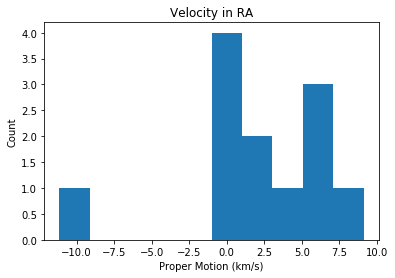

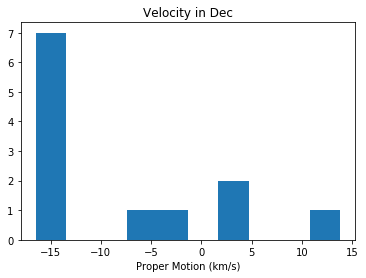

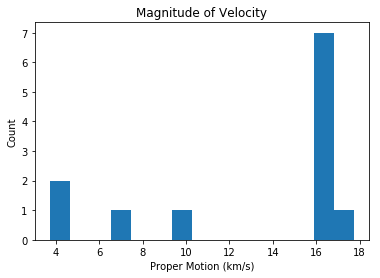

In [38]:
YSO_W40 = CalculateProperties('W40',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_regionW40\
                             ,adj=[0,0,0,0])
print(sky_regionW40)

ConditionToRegion(YSO_W40,YSO_W40['parsn10'])

## West Arm

Number of West Arm matches in the correct distance interval: 15
Number of _match with parallax > 5, 10, 20:  14 8 5
For parallax S/N > 10:
The mean velocity in ra is  2.89212275518 +/- 0.404824906783
The mean velocity in dec is  -17.3103716842 +/- 0.367515520884
The median velocity in ra is  2.94549001897 +/- 0.507372778809
The median proper velocity in dec is  -17.2443044433 +/- 0.460612398006
For all YSOs:
The mean magnitude of velocity is 17.9068572168 +/- 0.396393820112
The median magnitude of velocity is 17.7160618316 +/- 0.496805978691
The standard deviation of velocity is 1.53522666383
The median parallax is 2.31367860064 with a standard deviation of  0.177174853793


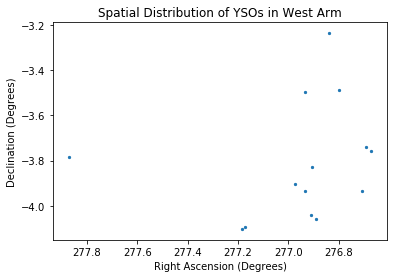

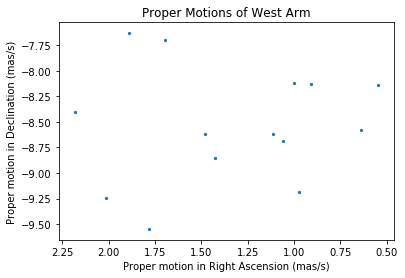

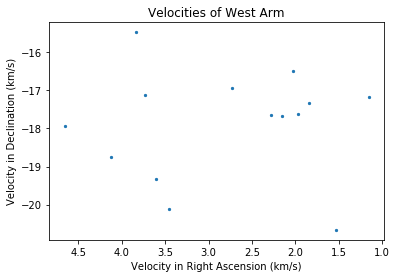

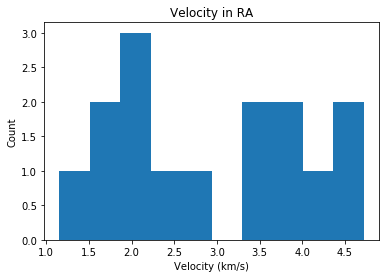

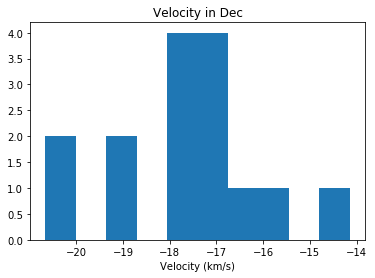

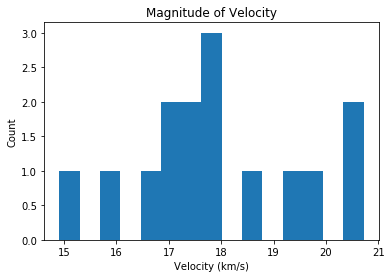

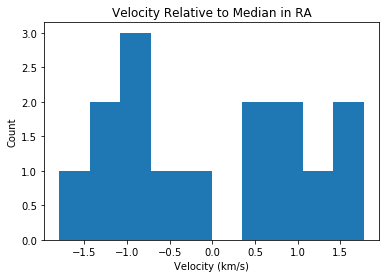

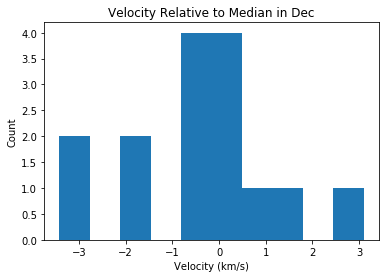

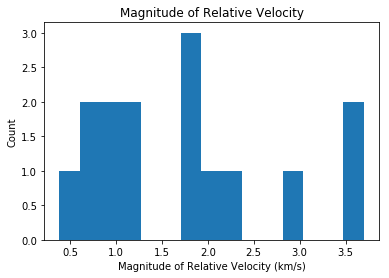

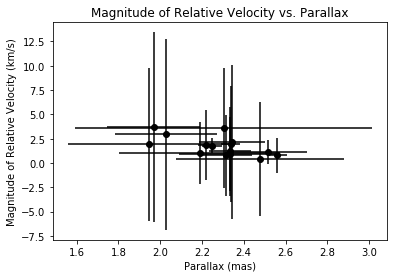

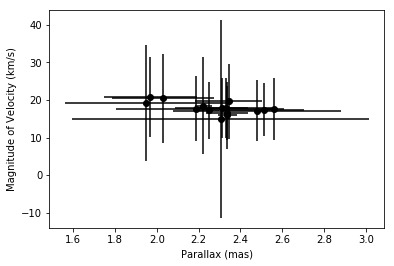

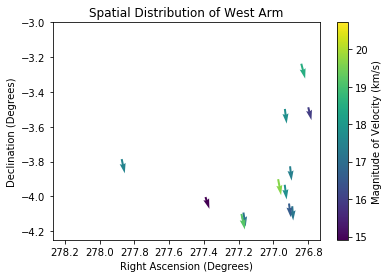

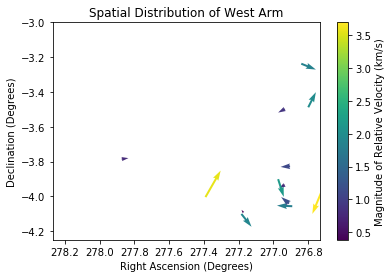

The median magnitude of proper motion is 17.4726404744 +/- 0.470803734141
The standard deviation of proper motion is 1.06249025079
The median parallax is 2.33605490176 with a standard deviation of  0.111103586525


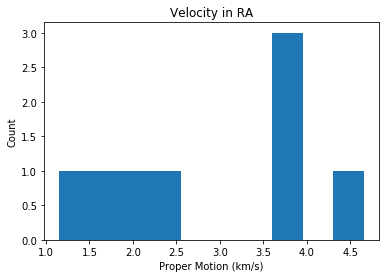

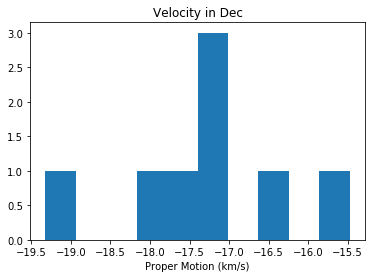

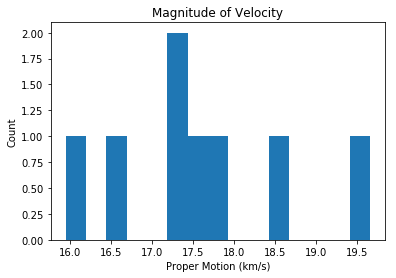

In [39]:
YSO_WestArm = CalculateProperties('West Arm',YSO_match,Gvalues,distance_range=[350.,550.],\
                                  sky_region = sky_region2d)

ConditionToRegion(YSO_WestArm,YSO_WestArm['parsn10'])

## Serpens Main

Number of Serpens Main matches in the correct distance interval: 61
Number of _match with parallax > 5, 10, 20:  57 39 15
For parallax S/N > 10:
The mean velocity in ra is  6.54416697611 +/- 0.323389671849
The mean velocity in dec is  -17.0731878112 +/- 0.958001634007
The median velocity in ra is  6.67767181707 +/- 0.40530884759
The median proper velocity in dec is  -17.6454042452 +/- 1.20067699147
For all YSOs:
The mean magnitude of velocity is 19.0595859136 +/- 0.34986260053
The median magnitude of velocity is 18.8908305958 +/- 0.438487743362
The standard deviation of velocity is 2.7325142624
The median parallax is 2.27869366981 with a standard deviation of  0.255909838478


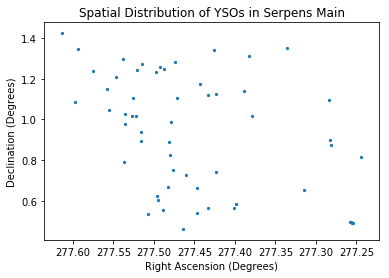

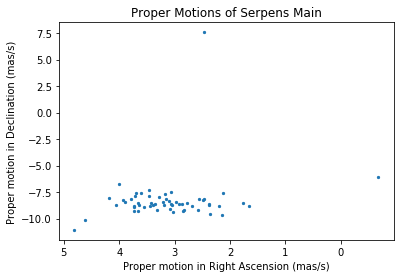

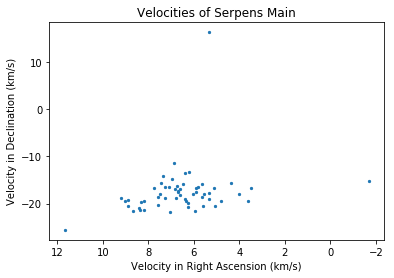

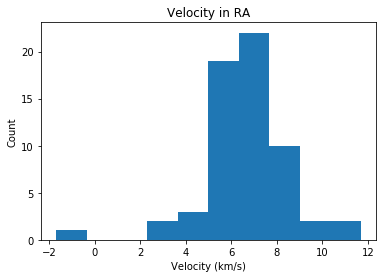

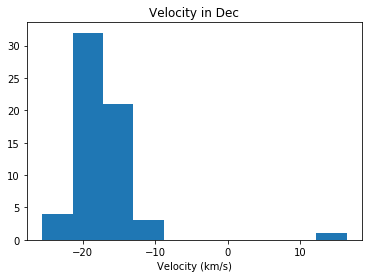

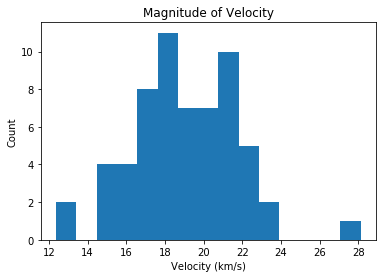

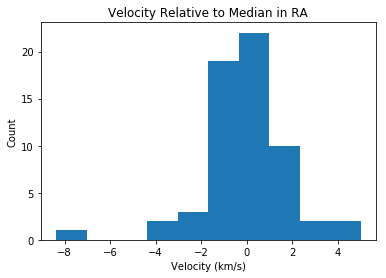

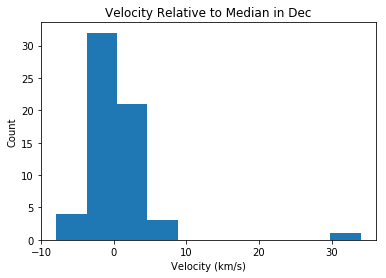

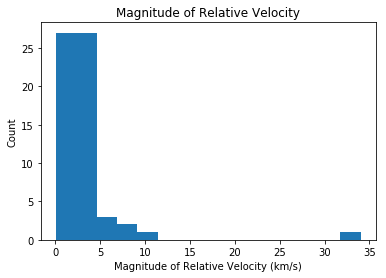

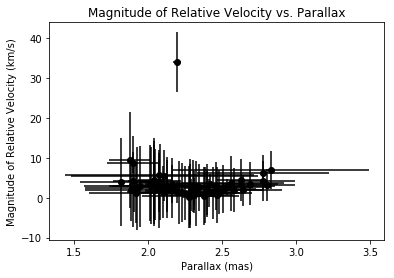

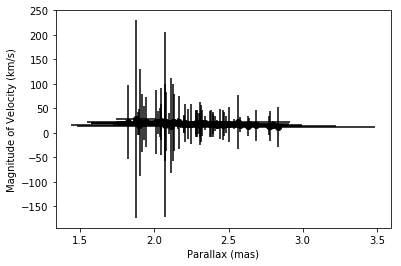

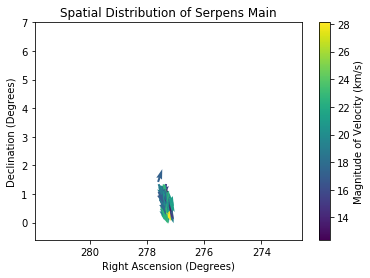

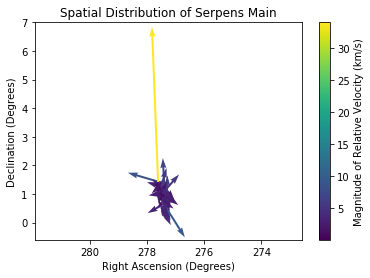

The median magnitude of proper motion is 18.6056012661 +/- 0.543680910264
The standard deviation of proper motion is 2.70904643559
The median parallax is 2.29146048655 with a standard deviation of  0.229930365006


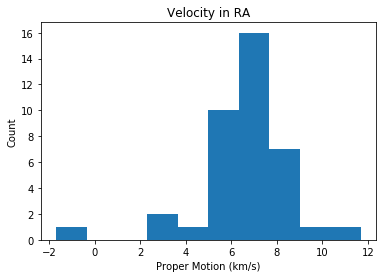

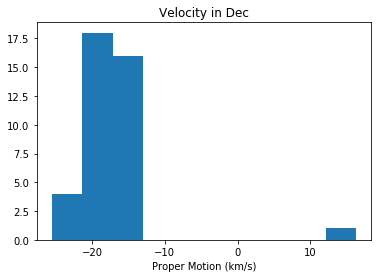

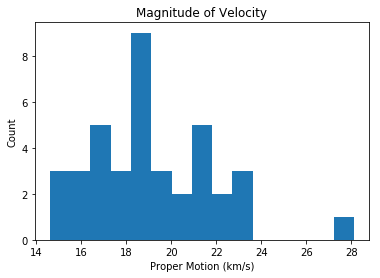

In [61]:
YSO_Main = CalculateProperties('Serpens Main',YSO_match,Gvalues, distance_range=[350.,550.],sky_region = sky_region3u, \
                               adj = [0,0,1,5])

ConditionToRegion(YSO_Main,YSO_Main['parsn10'])

## Serpens B

Number of Serpens B matches in the correct distance interval: 20
Number of _match with parallax > 5, 10, 20:  20 14 8
For parallax S/N > 10:
The mean velocity in ra is  6.49386867492 +/- 0.674015496535
The mean velocity in dec is  -15.3210214817 +/- 1.59997821809
The median velocity in ra is  6.79892080576 +/- 0.844753150578
The median proper velocity in dec is  -17.0419675954 +/- 2.00527532013
For all YSOs:
The mean magnitude of velocity is 17.8249923023 +/- 0.711507870057
The median magnitude of velocity is 18.567697255 +/- 0.891742872354
The standard deviation of velocity is 3.18195992795
The median parallax is 2.27252981446 with a standard deviation of  0.166129824217


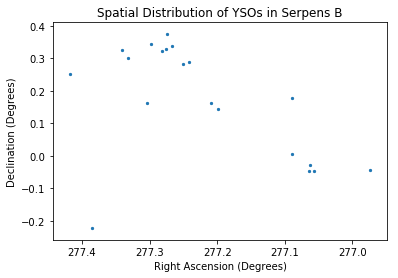

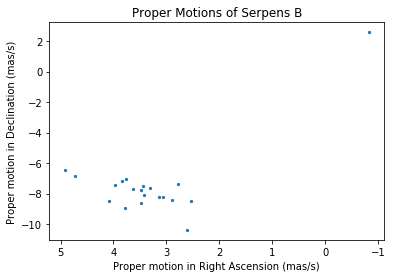

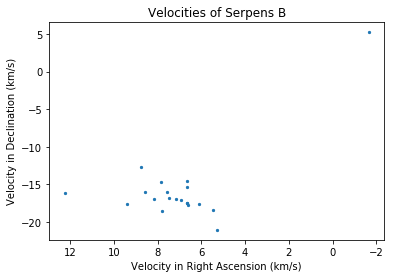

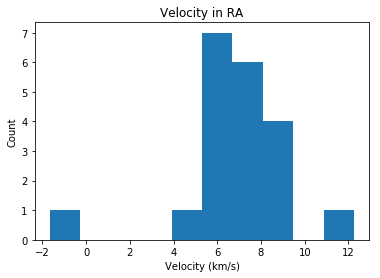

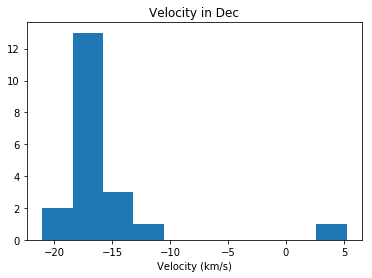

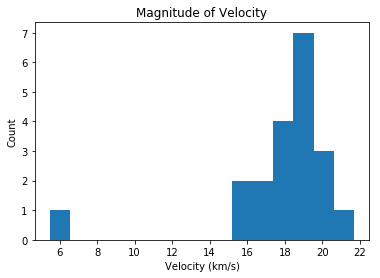

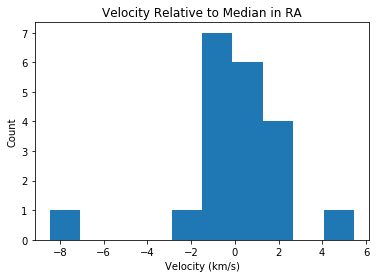

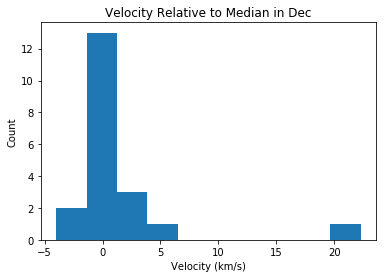

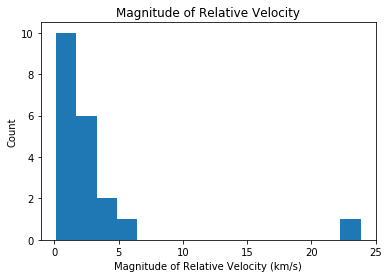

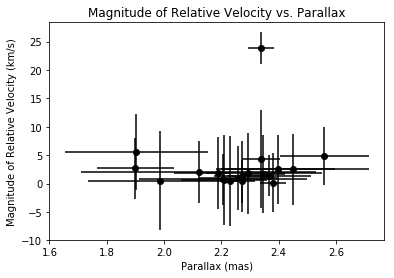

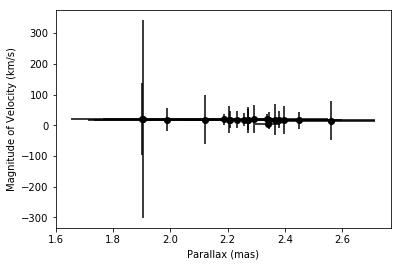

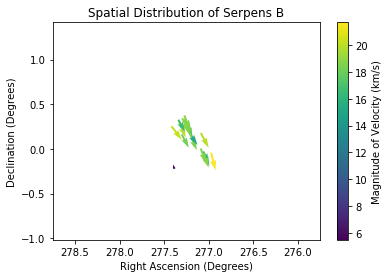

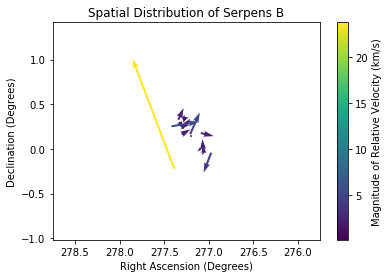

The median magnitude of proper motion is 18.567697255 +/- 1.21848029885
The standard deviation of proper motion is 3.63766407407
The median parallax is 2.30557867536 with a standard deviation of  0.141578917173


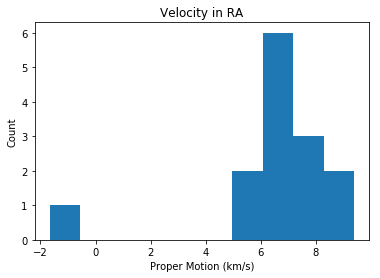

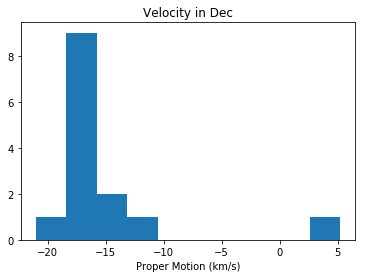

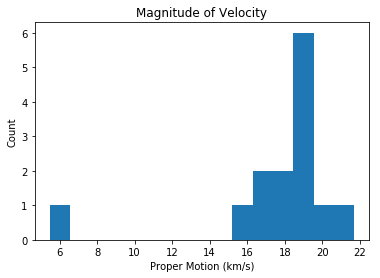

In [56]:
#Serpens B

YSO_B = CalculateProperties('Serpens B',YSO_match,Gvalues,distance_range=[350.,550.],sky_region = sky_region3d,\
                           adj = [1,1,4,5])

ConditionToRegion(YSO_B,YSO_B['parsn10'])

## Check Outliers

There are 2 outliers


The index is  [[4]]
The GAIA list number is 51532
The outlier is at a distance of 502.55 +/- 252.56042024 pc
The proper motion deviation magnitude is 18.3421836434 +/- 2.04249719129 km/s
The proper motion magnitude is  3.48692097225 +/-

C:\Users\Roxana\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
C:\Users\Roxana\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10


 10.720017148 km/s
pmmag/error (need to check) 0.32527195844
pmmag/median 0.185979414744
plx 1.9898363226
plx/error 40.8754021814
The GB index 1258
The difference in RA is  0.144 arcseconds
The difference in Dec is  0.13 arcseconds
The Gould_Belt_ID is  SSTGBS J183715.8+000-2656
alpha is -2.52


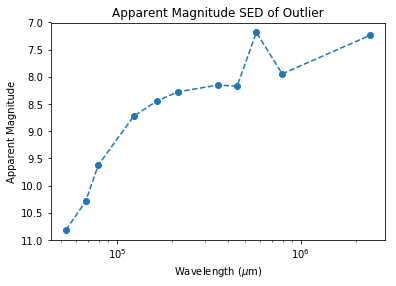

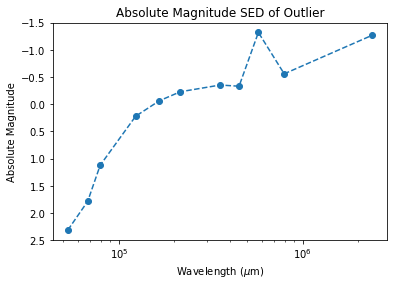

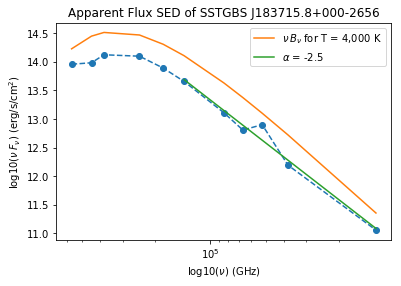

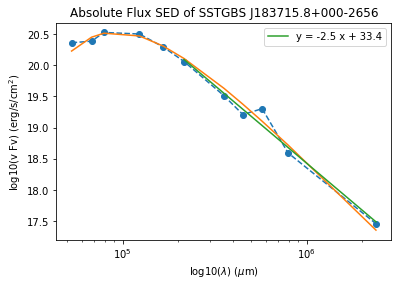

The index is  [[13]]
The GAIA list number is 56713
The outlier is at a distance of 381.8 +/- 145.773114527 pc
The proper motion deviation magnitude is 11.8175333223 +/- 3.4046042117 km/s
The proper motion magnitude is  8.31417021807 +/- 3.3418645955 km/s
pmmag/error (need to check) 2.48788362917
pmmag/median 0.443446961817
plx 2.61915550124
plx/error 7.26782179958
The GB index 1326
The difference in RA is  0.091 arcseconds
The difference in Dec is  0.086 arcseconds
The Gould_Belt_ID is  SSTGBS J183820.9+002917
alpha is -1.49


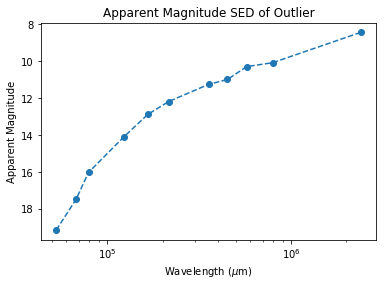

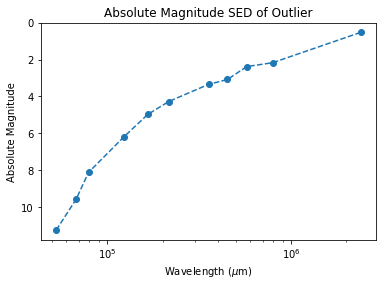

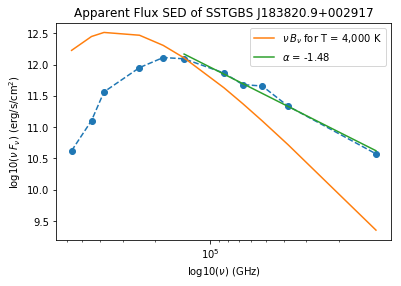

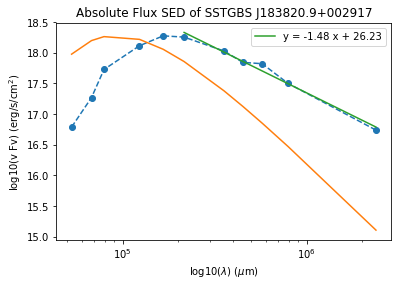

In [84]:
#Serpens East

shift1 = [5,3,4,9,9,9,9,9,9,9,9,9]
shift2 = [11,8.75,9.5,9,9,9,9,9,9]

CheckOutlier(YSO_East,YSO_match,c2dYSO_match,GTab,Gdist,GBYSO,shift1,shift2)

There are 5 outliers


The index is  [[0]]
The GAIA list number is 6782
The outlier is at a distance of 483.4 +/- 233.672123831 pc
The proper motion deviation magnitude is 15.0437811961 +/- 3.77201594345 km/s
The proper motion magnitude is  7.01355386525 +/- 74.8712906368 km/s
pmmag/error (need to check) 0.0936748092039
pmmag/median 

C:\Users\Roxana\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
C:\Users\Roxana\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10


0.469110691166
plx 2.06869539205
plx/error 11.0791367703
The GB index 520
The difference in RA is  0.085 arcseconds
The difference in Dec is  0.1 arcseconds
The Gould_Belt_ID is  SSTGBS J182957.4-015154
alpha is -1.31


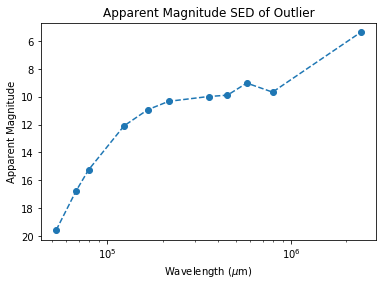

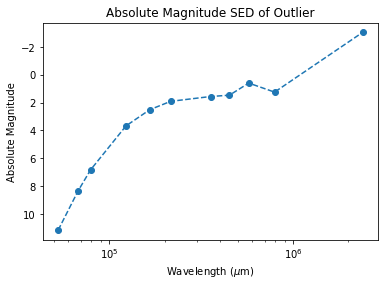

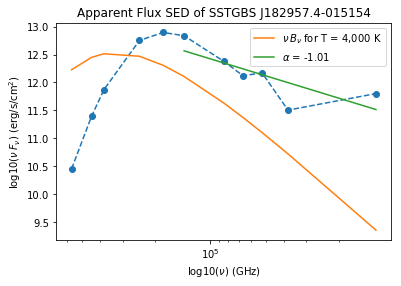

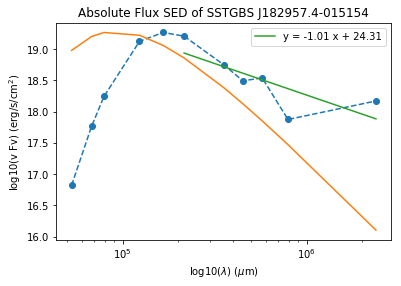

The index is  [[1]]
The GAIA list number is 3762
The outlier is at a distance of 470.68 +/- 221.535591009 pc
The proper motion deviation magnitude is 11.1922984071 +/- 4.19265642439 km/s
The proper motion magnitude is  4.58861601424 +/- 2.15416673085 km/s
pmmag/error (need to check) 2.13011181935
pmmag/median 0.306915562537
plx 2.12460522856
plx/error 45.2177127808
The GB index 690
The difference in RA is  0.094 arcseconds
The difference in Dec is  0.054 arcseconds
The Gould_Belt_ID is  SSTGBS J183033.2-015256
alpha is -1.38


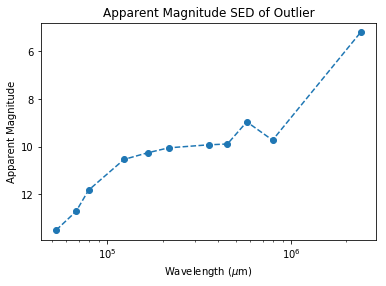

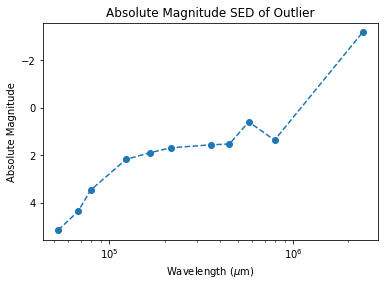

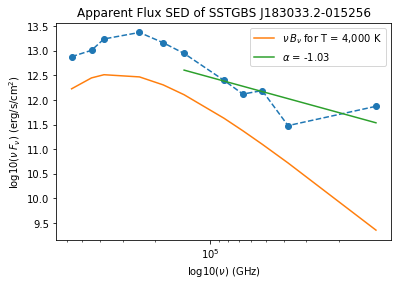

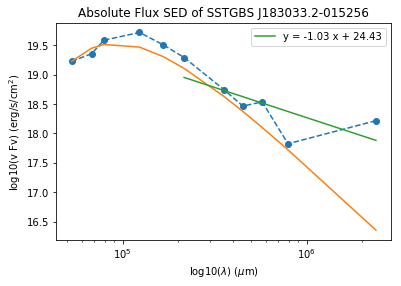

The index is  [[3]]
The GAIA list number is 3527
The outlier is at a distance of 394.29 +/- 155.461977306 pc
The proper motion deviation magnitude is 31.9589591438 +/- 6.30974410029 km/s
The proper motion magnitude is  17.7470197225 +/- 139.454770113 km/s
pmmag/error (need to check) 0.127260040715
pmmag/median 1.18703254414
plx 2.53622574327
plx/error 74.2138233088
The GB index 762
The difference in RA is  0.025 arcseconds
The difference in Dec is  0.029 arcseconds
The Gould_Belt_ID is  SSTGBS J183057.1-020543
alpha is -2.04


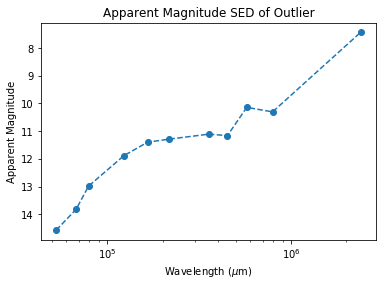

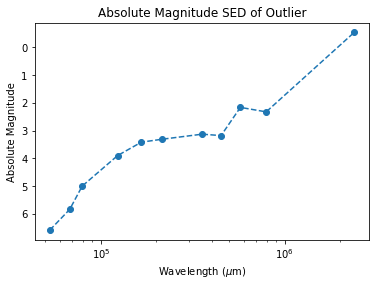

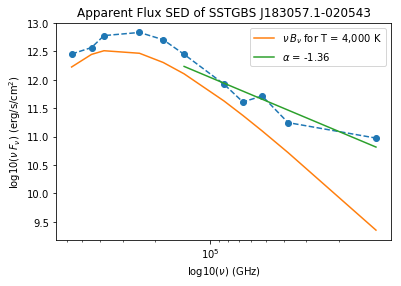

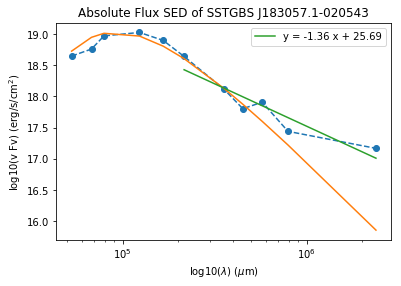

The index is  [[4]]
The GAIA list number is 3813
The outlier is at a distance of 412.08 +/- 169.808020375 pc
The proper motion deviation magnitude is 19.2534600951 +/- 3.92913643674 km/s
The proper motion magnitude is  3.71852353347 +/- 1.48528841916 km/s
pmmag/error (need to check) 2.50357000399
pmmag/median 0.248718292953
plx 2.42672687895
plx/error 47.1941761591
The GB index 793
The difference in RA is  0.065 arcseconds
The difference in Dec is  0.064 arcseconds
The Gould_Belt_ID is  SSTGBS J183105.0-020318
alpha is -1.93


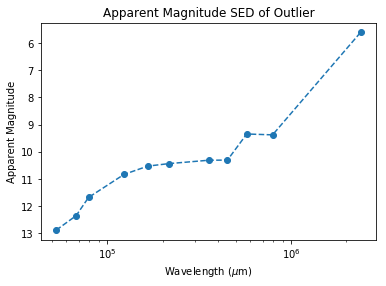

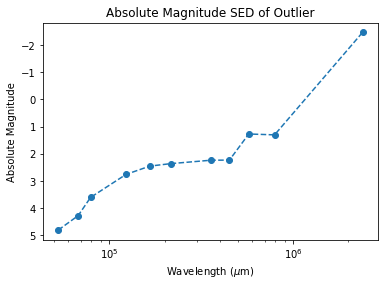

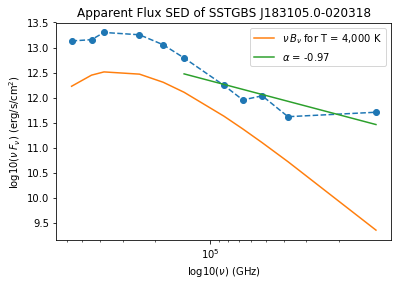

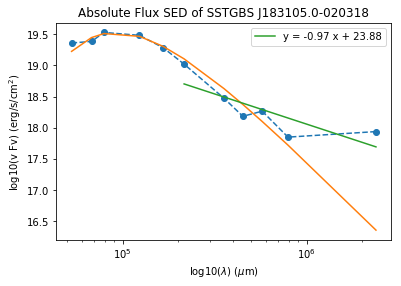

The index is  [[17]]
The GAIA list number is 44626
The outlier is at a distance of 409.52 +/- 167.706899372 pc
The proper motion deviation magnitude is 19.4410892934 +/- 3.81101270015 km/s
The proper motion magnitude is  9.36029484106 +/- 124.405079173 km/s
pmmag/error (need to check) 0.0752404556411
pmmag/median 0.626075519882
plx 2.44188122213
plx/error 30.1823782873
The GB index 1093
The difference in RA is  0.037 arcseconds
The difference in Dec is  0.008 arcseconds
The Gould_Belt_ID is  SSTGBS J183230.1-020413
alpha is -1.7


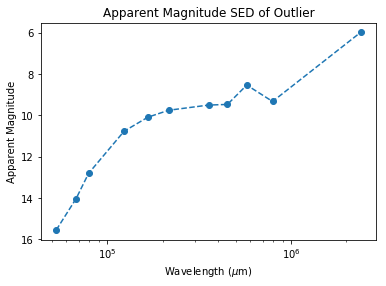

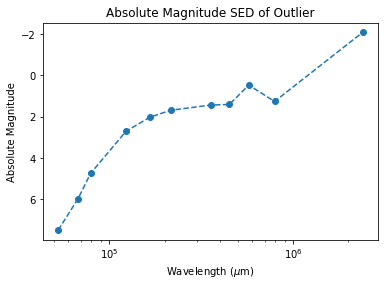

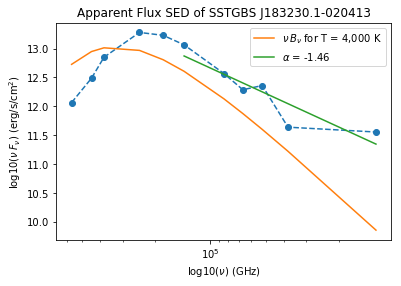

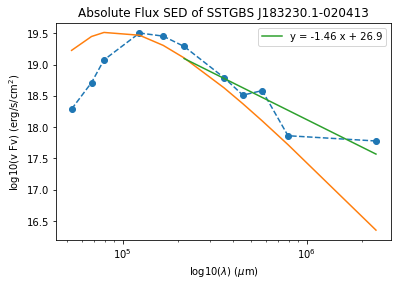

In [89]:
#W40

shift1 = [3,3,3,3,3.5,3,3,3]
shift2 = [9.75,10,9.5,10,10,9]

CheckOutlier(YSO_W40,YSO_match,c2dYSO_match,GTab,Gdist,GBYSO,shift1,shift2)

There are 1 outliers


The index is  [[60]]
The GAIA list number is 36497
The outlier is at a distance of 455.21 +/- 207.214095121 pc
The proper motion deviation magnitude is 34.0144031608 +/- 7.53089154609 km/s
The proper motion magnitude is  17.1903152399 +/- 16.8343593236 km/s
pmmag/error (need to check) 1.02114460725
pmmag/median 0.909981969965

C:\Users\Roxana\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10



plx 2.19679915665
plx/error 83.3629887745
The c2d index is 261
The difference in RA is  0.233830692537 arcseconds
The difference in Decliantion is  0.0511072749808 arcseconds
The c2d_ID is  SSTc2d J183027.2+012523
alpha is -2.5


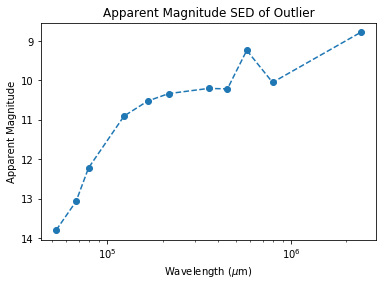

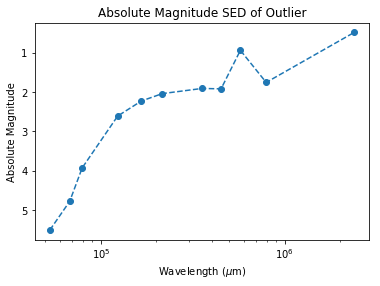

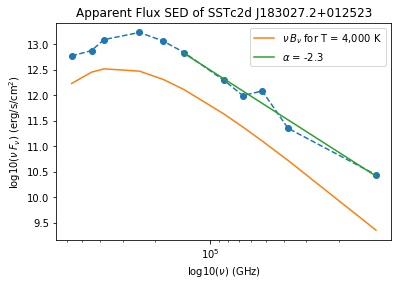

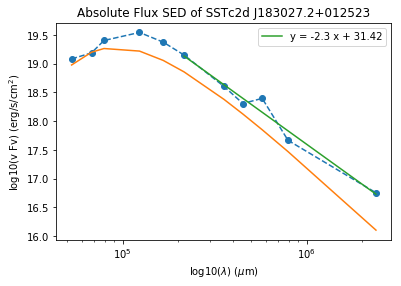

In [90]:
#Serpens Main

shift1 = [3,3,3,3,3,3,3,3,3,3]
shift2 = [9.75,10.5,9.5,10,10]

CheckOutlier(YSO_Main,YSO_match,c2dYSO_match,GTab,Gdist,GBYSO,shift1,shift2)

There are 1 outliers


The index is  [[18]]
The GAIA list number is 59932
The outlier is at a distance of 427.46 +/- 182.725440098 pc
The proper motion deviation magnitude is 23.8140228595 +/- 2.83524111276 km/s
The proper motion magnitude is  5.47655835102 +/- 2.39751540114 km/s
pmmag/error (need to check) 2.28426409625
pmmag/median 0.29495086417
plx 2.33937848654
plx/error 52.1638464609
The c2d index is 116
The difference in RA is  

C:\Users\Roxana\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10


0.165607941312 arcseconds
The difference in Decliantion is  0.262502044723 arcseconds
The c2d_ID is  SSTc2d J182932.5+000-1323
alpha is -2.51


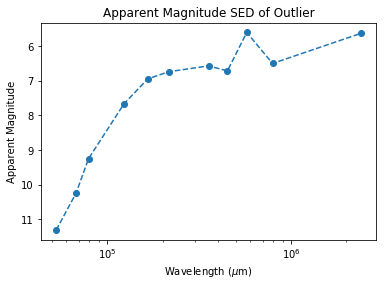

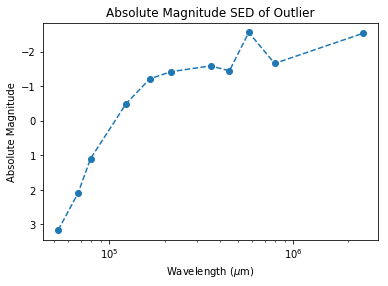

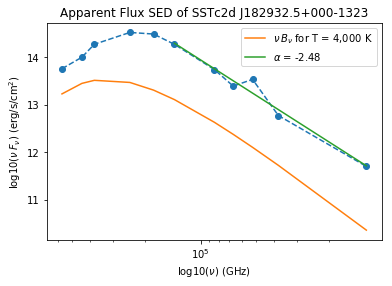

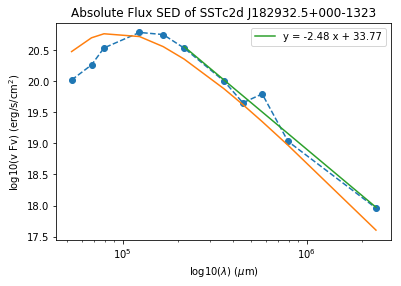

In [92]:
#Serpens B 

shift1 = [4,3,3,3,3,3,3,3,3,3]
shift2 = [11.25,10,9.5,10,10]

CheckOutlier(YSO_B,YSO_match,c2dYSO_match,GTab,Gdist,GBYSO,shift1,shift2)

In [88]:
#compare W40 and Serpens South

s,p = scipy.stats.ks_2samp(YSO_W40['pmmag'],YSO_S['pmmag'])
print(p)
s2,p2 = scipy.stats.ks_2samp(YSO_S['pmmag'],YSO_W40['pmmag'])
print(p2)

#compare W40 and Serpens South
s3,p3 = scipy.stats.ks_2samp(YSO_Main['pmmag'],YSO_B['pmmag'])
print(p3)
s4,p4 = scipy.stats.ks_2samp(YSO_B['pmmag'],YSO_Main['pmmag'])
print(p4)


0.462103763227
0.462103763227
0.170271018899
0.170271018899


## Plots of Regions

[ 18.34218364  11.81753332  15.0437812   11.19229841  31.95895914
  19.2534601   19.44108929  34.01440316  23.81402286]


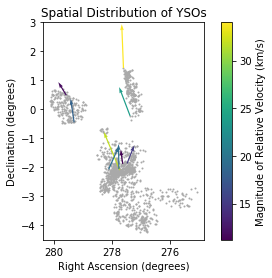

In [29]:
#Arrays of coordinates and relative velocities of outliers
RAs = np.array([YSO_East['ra'][4],YSO_East['ra'][13],YSO_W40['ra'][0],YSO_W40['ra'][1],YSO_W40['ra'][3],YSO_W40['ra'][4],\
                YSO_W40['ra'][17],YSO_Main['ra'][60],YSO_B['ra'][18]])
DECs = np.array([YSO_East['dec'][4],YSO_East['dec'][13],YSO_W40['dec'][0],YSO_W40['dec'][1],YSO_W40['dec'][3],YSO_W40['dec'][4],\
                YSO_W40['dec'][17],YSO_Main['dec'][60],YSO_B['dec'][18]])
RPMRAs = np.array([YSO_East['rpmra'][4],YSO_East['rpmra'][13],YSO_W40['rpmra'][0],YSO_W40['rpmra'][1],\
                YSO_W40['rpmra'][3],YSO_W40['rpmra'][4],YSO_W40['rpmra'][17],YSO_Main['rpmra'][60],\
                   YSO_B['rpmra'][18]])
RPMDECs = np.array([YSO_East['rpmdec'][4],YSO_East['rpmdec'][13],YSO_W40['rpmdec'][0],YSO_W40['rpmdec'][1],\
                YSO_W40['rpmdec'][3],YSO_W40['rpmdec'][4],YSO_W40['rpmdec'][17],YSO_Main['rpmdec'][60],\
                    YSO_B['rpmdec'][18]])
RPMMAGs = np.array([YSO_East['rpmmag'][4],YSO_East['rpmmag'][13],YSO_W40['rpmmag'][0],YSO_W40['rpmmag'][1],\
                YSO_W40['rpmmag'][3],YSO_W40['rpmmag'][4],YSO_W40['rpmmag'][17],YSO_Main['rpmmag'][60],\
                    YSO_B['rpmmag'][18]])
print(RPMMAGs)

#Plot all YSOs and indicate outliers with arrows
figure = plt.figure()
plt.scatter(c2dYSOra,c2dYSOdec,c='darkgray',s=1)
plt.scatter(GBYSOra[GBYSOra > 275],GBYSOdec[GBYSOra > 275],c='darkgray',s=1)
plt.quiver(RAs,DECs,RPMRAs,RPMDECs,RPMMAGs,scale=125)
c = plt.colorbar()
c.set_label('Magnitude of Relative Velocity (km/s)')
plt.ylim(-4.5,3)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Spatial Distribution of YSOs')
plt.savefig('Figures/Comparison.png',dpi=400)
plt.show()

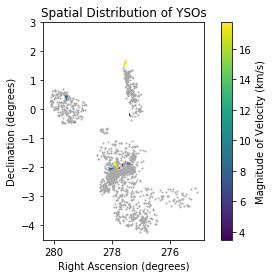

In [96]:
#Arrays of coordinates and relative velocities of outliers
RAs = np.array([YSO_East['ra'][4],YSO_East['ra'][13],YSO_W40['ra'][0],YSO_W40['ra'][1],YSO_W40['ra'][3],YSO_W40['ra'][4],\
                YSO_W40['ra'][17],YSO_Main['ra'][60],YSO_B['ra'][18]])
DECs = np.array([YSO_East['dec'][4],YSO_East['dec'][13],YSO_W40['dec'][0],YSO_W40['dec'][1],YSO_W40['dec'][3],YSO_W40['dec'][4],\
                YSO_W40['dec'][17],YSO_Main['dec'][60],YSO_B['dec'][18]])
pmras = np.array([YSO_East['pmra'][4],YSO_East['pmra'][13],YSO_W40['pmra'][0],YSO_W40['pmra'][1],\
                YSO_W40['pmra'][3],YSO_W40['pmra'][4],YSO_W40['pmra'][17],YSO_Main['pmra'][60],\
                   YSO_B['pmra'][18]])
pmdecs = np.array([YSO_East['pmdec'][4],YSO_East['pmdec'][13],YSO_W40['pmdec'][0],YSO_W40['pmdec'][1],\
                YSO_W40['pmdec'][3],YSO_W40['pmdec'][4],YSO_W40['pmdec'][17],YSO_Main['pmdec'][60],\
                    YSO_B['pmdec'][18]])
pmmags = np.array([YSO_East['pmmag'][4],YSO_East['pmmag'][13],YSO_W40['pmmag'][0],YSO_W40['pmmag'][1],\
                YSO_W40['pmmag'][3],YSO_W40['pmmag'][4],YSO_W40['pmmag'][17],YSO_Main['pmmag'][60],\
                    YSO_B['pmmag'][18]])
#print(pmmags)

#Plot all YSOs and indicate outliers with arrows
figure = plt.figure()
plt.scatter(c2dYSOra,c2dYSOdec,c='darkgray',s=1)
plt.scatter(GBYSOra[GBYSOra > 275],GBYSOdec[GBYSOra > 275],c='darkgray',s=1)
plt.quiver(RAs,DECs,pmras,pmdecs,pmmags,scale=125)
c = plt.colorbar()
c.set_label('Magnitude of Velocity (km/s)')
plt.ylim(-4.5,3)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Spatial Distribution of YSOs')
#plt.savefig('Figures/Comparison.png',dpi=400)
plt.show()

In [30]:
#parsecs per degree
pcperdeg = 3600*450/206265

#Degrees traveled in 500,000 years
arrows = RPMMAGs/pcperdeg/2
print(arrows)

[ 1.16770077  0.75232824  0.95771776  0.71252452  2.03457244  1.22571449
  1.23765935  2.16542619  1.51604921]


There are a total of 1704 YSOs
There are a total of 195 matched YSOs


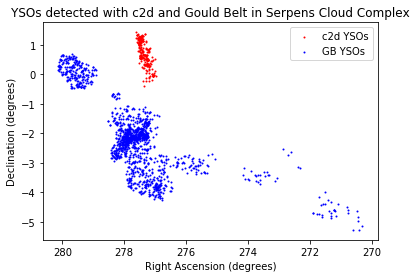

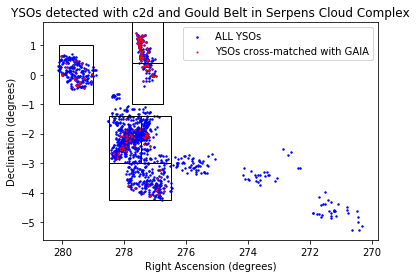

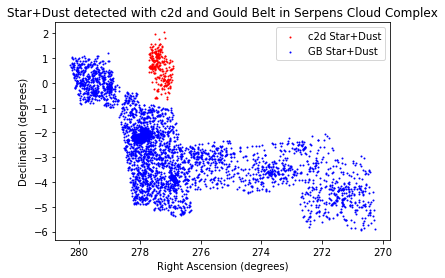

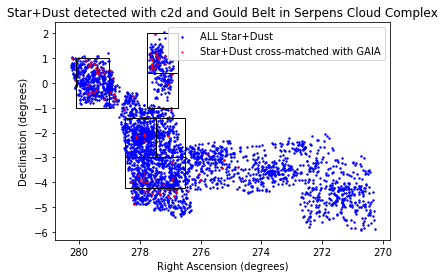

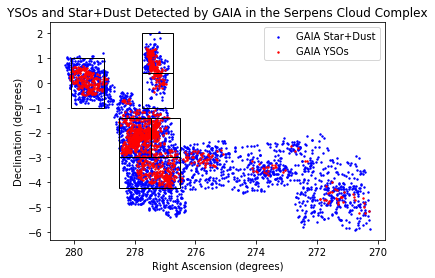

In [31]:
#combine ra and dec for all YSOs into an array for ra and an array for dec
c2dYSOra_data = np.array(c2dYSOra.data)
c2dYSOdec_data = np.array(c2dYSOdec.data)
GBYSOra_data = np.array(GBYSOra.data)
GBYSOdec_data = np.array(GBYSOdec.data)
YSO_ra = c2dYSOra_data; YSO_ra = np.append(YSO_ra,GBYSOra_data)
YSO_dec = c2dYSOdec_data; YSO_dec = np.append(YSO_dec,GBYSOdec_data)
print('There are a total of',len(YSO_ra),'YSOs')
print('There are a total of',len(YSO_ra[YSO_match >-1]),'matched YSOs')

#combine ra and dec for all star+dust into an array for ra and an array for dec
c2dSDra_data = np.array(c2dSDra.data)
c2dSDdec_data = np.array(c2dSDdec.data)
GBSDra_data = np.array(GBSDra.data)
GBSDdec_data = np.array(GBSDdec.data)
SD_ra = c2dSDra_data; SD_ra = np.append(SD_ra,GBSDra_data)
SD_dec = c2dSDdec_data; SD_dec = np.append(SD_dec,GBSDdec_data)

#Plot of c2d and Gould Belt YSOs
figure = plt.figure()
plt.scatter(c2dYSOra_data,c2dYSOdec_data,c='r',label = 'c2d YSOs',s=1)
plt.scatter(GBYSOra_data,GBYSOdec_data,c='b',label = 'GB YSOs',s=1)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.show()

#Plot of matched YSOs and all YSOs
figure = plt.figure()
plt.scatter(YSO_ra,YSO_dec,c='b',s=2,label='ALL YSOs')
plt.scatter(YSO_ra[YSO_match >-1],YSO_dec[YSO_match >-1],c='r',s=1,label='YSOs cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/YSO_plot.png')
plt.show()

#Plot of c2d and Gould Belt star+dust
figure = plt.figure()
plt.scatter(c2dSDra_data,c2dSDdec_data,c='r',label = 'c2d Star+Dust',s=1)
plt.scatter(GBSDra_data,GBSDdec_data,c='b',label = 'GB Star+Dust',s=1)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Star+Dust detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.show()

#Plot of matched star+dust and all star+dust
figure = plt.figure()
plt.scatter(SD_ra,SD_dec,c='b',s=2,label='ALL Star+Dust')
plt.scatter(SD_ra[SD_match >-1],SD_dec[SD_match >-1],c='r',s=1,label='Star+Dust cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Star+Dust detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/Star+Dust_plot.png')
plt.show()

#Plot of YSOs and star +dust in GAIA
figure = plt.figure()
plt.scatter(SD_ra,SD_dec,c='b',s=2,label='GAIA Star+Dust')
plt.scatter(YSO_ra,YSO_dec,c='r',s=2,label='GAIA YSOs')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs and Star+Dust Detected by GAIA in the Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().add_patch(Rectangle((ra_minS,dec_minS),widthS,heightS,fill=False))
plt.gca().add_patch(Rectangle((ra_min2d,dec_min2d),width2d,height2d,fill=False))
plt.gca().add_patch(Rectangle((ra_min3u,dec_min3u),width3u,height3u,fill=False))
plt.gca().add_patch(Rectangle((ra_min3d,dec_min3d),width3d,height3d,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/YSO_SD_plot.png')
plt.show()